In [253]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
import folium
from sklearn import preprocessing
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.colors as colors
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from helpers import *
from ipywidgets import SelectMultiple, RadioButtons, interact, Layout
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [254]:
en = 'environment/'
cl = 'crops_and_livestock/'
er = 'energy_resources/'

CROPS = 'Production_Crops_E_All_Data_NOFLAG.csv'
LIVE_STOCK = 'Production_LivestockPrimary_E_All_Data_NOFLAG.csv'
VALUE_PROD = 'Value_of_Production_E_All_Data_NOFLAG.csv'
EMISSIONS = 'Emissions_Agriculture_Agriculture_total_E_All_Data_NOFLAG.csv'
PESTICIDES = 'Inputs_Pesticides_Use_E_All_Data_NOFLAG.csv'
TRADE = 'Trade_Crops_Livestock_E_All_Data_NOFLAG.csv'
ENERGY = 'Energy.csv'
LAND = 'LandUse.csv'
WATER = 'Water.csv'
SOIL = 'Soil.csv'
CLIMATE = 'Environment_Temperature_change_E_All_Data_NOFLAG.csv'

In [255]:
world_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = set(world_df['name'])

## Crops Production

We start our analysis from the agriculture and livestock datasets.

In [256]:
# Loading the DataSet
crops = pd.read_csv(cl+CROPS, encoding = "ISO-8859-1")

In [257]:
# See how the data is organized
crops.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,ha,NaN,NaN,NaN,...,12000.0,11029.0,11210.0,13469.0,13490.0,14114.0,13703.0,14676.0,19481.0,19793.0
1,2,Afghanistan,221,"Almonds, with shell",5419,Yield,hg/ha,NaN,NaN,NaN,...,35000.0,39154.0,49955.0,45000.0,45960.0,29910.0,19996.0,16521.0,16859.0,13788.0
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,42000.0,43183.0,56000.0,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0
3,2,Afghanistan,711,"Anise, badian, fennel, coriander",5312,Area harvested,ha,NaN,NaN,NaN,...,15000.0,17748.0,17000.0,19500.0,18500.0,18500.0,30000.0,25000.0,26019.0,28873.0
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",5419,Yield,hg/ha,NaN,NaN,NaN,...,6000.0,6203.0,6000.0,6414.0,6757.0,6757.0,7167.0,7200.0,6923.0,6830.0


We now create a function to get all the unique values from the columns `Item`, `Element` and `Unit` in order to better understand what data is contained in the dataset.

In [258]:
def uniquevalues(df):
    for i in ['Item', 'Element', 'Unit', 'Area']:
        print(i)
        print(df[i].unique())

In [259]:
uniquevalues(crops)

Item
['Almonds, with shell' 'Anise, badian, fennel, coriander' 'Apples'
 'Apricots' 'Barley' 'Berries nes' 'Cotton lint' 'Cottonseed' 'Figs'
 'Fruit, citrus nes' 'Fruit, fresh nes' 'Fruit, stone nes' 'Grapes'
 'Linseed' 'Maize' 'Melons, other (inc.cantaloupes)' 'Millet' 'Nuts, nes'
 'Olives' 'Onions, dry' 'Oranges' 'Peaches and nectarines' 'Pears'
 'Pistachios' 'Plums and sloes' 'Potatoes' 'Pulses, nes' 'Rice, paddy'
 'Seed cotton' 'Sesame seed' 'Spices, nes' 'Sugar beet' 'Sugar cane'
 'Sunflower seed' 'Vegetables, fresh nes' 'Walnuts, with shell'
 'Watermelons' 'Wheat' 'Cereals (Rice Milled Eqv)' 'Cereals,Total'
 'Citrus Fruit,Total' 'Coarse Grain, Total' 'Fibre Crops Primary'
 'Fruit Primary' 'Oilcrops, Cake Equivalent' 'Oilcrops, Oil Equivalent'
 'Pulses,Total' 'Roots and Tubers,Total' 'Treenuts,Total'
 'Vegetables Primary' 'Beans, dry' 'Beans, green'
 'Broad beans, horse beans, dry' 'Cabbages and other brassicas'
 'Carrots and turnips' 'Cauliflowers and broccoli' 'Cherries'
 'Cherr

As we can see, in the `Item` column, the kind of vegetable or fruit considered is reported. In the `Element` columns we have instead either the harvested area, the amount produced or the yield which is the harvested production per unit of harvested area for all the crop products.

For each `Element` there is a different unit parameter (as stated in the FAO website): 
- Production : tonnes
- Area harvested: hectares
- Yield: tonnes per hectare.

We decided to keep only Production, this because this feature is the more significant for the purpose of the project in general. **We are probably going to consider the `Area harvest` when we will talk about the energy source consuption**.

In [260]:
# Save the data in a new DF and see the result
crops_production = crops[crops['Element']=='Production']
crops_production.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,42000.0,43183.0,56000.0,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0
5,2,Afghanistan,711,"Anise, badian, fennel, coriander",5510,Production,tonnes,NaN,NaN,NaN,...,9000.0,11008.0,10200.0,12508.0,12500.0,12500.0,21500.0,18000.0,18012.0,19719.0
8,2,Afghanistan,515,Apples,5510,Production,tonnes,15100.0,15100.0,15100.0,...,56061.0,72765.0,59850.0,62041.0,70000.0,78597.0,89403.0,89733.0,140903.0,175000.0
11,2,Afghanistan,526,Apricots,5510,Production,tonnes,32000.0,32000.0,32000.0,...,59559.0,60000.0,66560.0,67995.0,83500.0,90000.0,90000.0,87686.0,17894.0,131816.0
14,2,Afghanistan,44,Barley,5510,Production,tonnes,378000.0,378000.0,378000.0,...,333000.0,486000.0,437000.0,305900.0,504000.0,514000.0,521000.0,403000.0,301856.0,94995.0


In [261]:
# Check that we have a unique unit now
crops_production.Element.unique()

array(['Production'], dtype=object)

Considering the `Area` column, we can see that there are rows that actually represent a region and not a specific Country. We want to drop these columns. \
There are also some countries that have changed over time such as Sudan that is classified as Sudan and Sudan(former). We want to collect the data and refer it to a unique country. \
Since the ultimate goal is to obtain a colormap of the world, we use the GeoPandas package. We then change the names of all the countries that have different names from the ones used by GeoPandas (e.g. 'Bosnia and Herzegovina' is replaced by 'Bosnia and Herz.').

In [262]:
changes = {'Area' : { 'Bosnia and Herzegovina' : 'Bosnia and Herz.' ,
                    'Brunei Darussalam' : 'Brunei',
                    'Czechoslovakia' : 'Czechia',
                    'Republic of Korea' : 'South Korea',
                    "Democratic People's Republic of Korea" : 'North Korea',
                    'Democratic Republic of the Congo' : 'Dem. Rep. Congo',
                    'Bolivia (Plurinational State of)' : 'Bolivia',
                    'Venezuela (Bolivarian Republic of)' : 'Venezuela',
                    'Republic of Moldova' : 'Moldova',
                    'Dominican Republic' : 'Dominican Rep.',
                    'Equatorial Guinea' : 'Eq. Guinea',
                    'Eswatini' : 'eSwatini',
                    'Ethiopia PDR' : 'Ethiopia',
                    'Iran (Islamic Republic of)' :'Iran',
                    'Serbia and Montenegro' : 'Serbia',
                    'Sudan (former)' : 'Sudan',
                    'South Sudan' : 'S. Sudan',
                    'Syrian Arab Republic' : 'Syria',
                    'The former Yugoslav Republic of Macedonia' : 'Macedonia',
                    'United Republic of Tanzania' : 'Tanzania',
                    'Viet Nam' : 'Vietnam',
                    'Russian Federation' : 'Russia',
                    'Central African Republic' : 'Central African Rep.',
                    'USSR' : 'Russia'
                    }}

In [263]:
crops_production = crops_production.replace(changes)

Since all the production is reported in terms of tonnes, at a first approximation we can report the total production of all the products. Therefore we group by the `Area` and sum the values.

In [264]:
# Calculate the total production
crops_production = crops_production.groupby('Area').sum()
to_drop = ['Area Code','Item Code','Element Code']
crops_production = crops_production.drop(to_drop, axis=1)

In [265]:
# Check the result
crops_production.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,14449553.0,14552363.0,13760181.0,14937994.0,15268828.0,14506150.0,15905949.0,16254255.0,16741652.0,14865815.0,...,1.790652e+07,2.626508e+07,2.408772e+07,1.950941e+07,2.518499e+07,2.568590e+07,2.745402e+07,2.482097e+07,2.650892e+07,2.303543e+07
Africa,423480037.0,458585565.0,474403817.0,467908364.0,477139676.0,472916996.0,536081551.0,527648249.0,553538449.0,573140624.0,...,1.529804e+09,1.550891e+09,1.650939e+09,1.652144e+09,1.766952e+09,1.823900e+09,1.912913e+09,1.890117e+09,1.913682e+09,1.976643e+09
Albania,1834736.0,1851616.0,1879998.0,2191526.0,2036088.0,2593408.0,2793449.0,2896387.0,2929318.0,3093970.0,...,4.743277e+06,4.971402e+06,5.599074e+06,5.867007e+06,6.005984e+06,6.015630e+06,6.104135e+06,6.284231e+06,6.549896e+06,6.611361e+06
Algeria,10003344.0,14717576.0,14497450.0,11158557.0,12683708.0,7397920.0,10275396.0,13381229.0,12248910.0,13127775.0,...,2.577084e+07,4.272033e+07,4.222562e+07,4.565594e+07,5.040224e+07,5.389180e+07,4.620347e+07,4.844512e+07,4.824687e+07,4.883251e+07
American Samoa,18942.0,20161.0,21640.0,20280.0,19102.0,19717.0,21001.0,21165.0,22620.0,21232.0,...,3.387900e+04,3.487200e+04,3.542200e+04,3.501700e+04,3.380500e+04,3.663800e+04,3.630200e+04,3.594900e+04,3.611000e+04,3.662300e+04


In the FAO's Datasets we have several information related to areas which are not state (e.g. `Europe`). Right now we don't need this information so drop those columns.

In [266]:
to_delete = set(crops_production.index).difference(countries)
crops_production = crops_production.drop(to_delete, axis=0)

In [267]:
# Check the result
crops_production.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,14449553.0,14552363.0,13760181.0,14937994.0,15268828.0,14506150.0,15905949.0,16254255.0,16741652.0,14865815.0,...,17906517.0,26265084.0,24087723.0,19509407.0,25184989.0,25685905.0,27454018.0,24820968.0,26508915.0,23035427.0
Albania,1834736.0,1851616.0,1879998.0,2191526.0,2036088.0,2593408.0,2793449.0,2896387.0,2929318.0,3093970.0,...,4743277.0,4971402.0,5599074.0,5867007.0,6005984.0,6015630.0,6104135.0,6284231.0,6549896.0,6611361.0
Algeria,10003344.0,14717576.0,14497450.0,11158557.0,12683708.0,7397920.0,10275396.0,13381229.0,12248910.0,13127775.0,...,25770841.0,42720333.0,42225620.0,45655942.0,50402239.0,53891805.0,46203471.0,48445121.0,48246871.0,48832513.0
Angola,7272990.0,7510739.0,7446103.0,7814161.0,7988142.0,7994293.0,8189404.0,8289375.0,9076422.0,9018910.0,...,32290900.0,41849132.0,44721696.0,48259060.0,35844603.0,54718300.0,40416561.0,41403163.0,48297903.0,54713126.0
Argentina,84126401.0,81811438.0,94643775.0,105810012.0,87452076.0,98297858.0,106090096.0,93230109.0,103246058.0,112360915.0,...,322068133.0,219717368.0,310758881.0,346637658.0,313969497.0,354936106.0,358636081.0,326358239.0,346113060.0,397781244.0


To better analyze data later, we compute and store the World total output, summing up all values in each column.

In [268]:
sumCol = crops_production.sum().rename("Total")

In [269]:
# Define the function norm
def norm(col):
    return col/col.sum()

Thank to this function, we know what was the "weight" of each state every year. In order to sum up, we create a new column `Total` where we take the mean among the years we are taking into account.

In [270]:
# Define years to keep
years = ['Y'+str(2000+x) for x in range(0,18)]

In [271]:
# Apply the norm function
crops_production['RecentPerc'] = crops_production[years].apply(norm).mean(axis=1)*100

In [273]:
crops_production.RecentPerc.head()

Area
Afghanistan    0.126968
Albania        0.030376
Algeria        0.219059
Angola         0.205894
Argentina      1.805485
Name: RecentPerc, dtype: float64

In [274]:
crops_production = crops_production.append(total)

We are interested to look at the countries which are more involved in production.

In [275]:
crops_production = crops_production.sort_values(by=['RecentPerc'], ascending=0)
crops_production.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,RecentPerc
Area,,,,,,,,,,,,,,,,,,,,,
China,714471303.0,751106166.0,778463723.0,820355841.0,898024660.0,976881165.0,9.918423e+08,9.757567e+08,9.910344e+08,1.080952e+09,...,3.473565e+09,3.598288e+09,3.773253e+09,3.893666e+09,3.987392e+09,4.019969e+09,4.239152e+09,4.252898e+09,4.306462e+09,21.089025
United States of America,825136398.0,827785815.0,879484338.0,817321849.0,921068690.0,924461734.0,1.020159e+09,1.008803e+09,1.030824e+09,9.584817e+08,...,2.054590e+09,1.982796e+09,1.913110e+09,1.806939e+09,2.120632e+09,2.183135e+09,2.026163e+09,2.210484e+09,2.081014e+09,11.768102
India,509302844.0,507219485.0,505295503.0,527392818.0,510595196.0,516534446.0,5.351902e+08,5.661369e+08,6.100005e+08,6.517203e+08,...,1.583003e+09,1.709879e+09,1.840832e+09,1.884968e+09,1.918287e+09,1.937776e+09,1.835925e+09,1.871303e+09,1.917748e+09,9.974561
Brazil,185970672.0,198589736.0,208617323.0,214010043.0,243174557.0,235838198.0,2.550073e+08,2.603057e+08,2.634741e+08,2.793573e+08,...,1.266699e+09,1.338637e+09,1.389616e+09,1.396991e+09,1.509356e+09,1.489970e+09,1.442525e+09,1.367597e+09,1.508072e+09,7.094662
Indonesia,101205455.0,109677166.0,100778814.0,113698333.0,108795132.0,111440888.0,1.045733e+08,1.193930e+08,1.193433e+08,1.258088e+08,...,5.502703e+08,5.701596e+08,5.782127e+08,6.188806e+08,6.288306e+08,6.146771e+08,5.940807e+08,6.228435e+08,6.451500e+08,3.101624


In [276]:
def mapp(result, result_name, world_df=world_df):
    plot_name = result.name
    merged = world_df.set_index('name').join(result)
    merged = merged.dropna(subset=[plot_name])
    vmin, vmax, vcenter = merged[plot_name].min(), merged[plot_name].max(), merged[plot_name].quantile(0.95)
    divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    ax = merged.plot(column=plot_name, figsize=(15,10),  k=9, norm=divnorm, cmap='OrRd', linewidth=1, edgecolor = "black",
                     legend=True, legend_kwds={'orientation': "horizontal"})
    ax.set_title(result_name)
    ax.figure.savefig(result_name+'.png')
    return

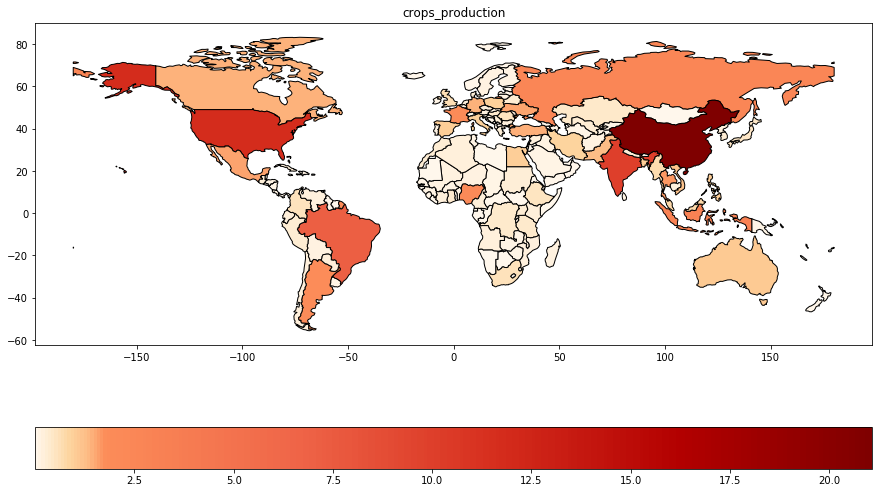

In [278]:
# World map
mapp(crops_production.RecentPerc,'crops_production')

We then define the function clean_df that does the cleaning we have seen so far. **We save the function in the file helpers.py**.

In [282]:
def clean_df(df, years, to_drop, changes):
    df = df.replace(changes)
    df = df.groupby('Area').sum()
    df = df.drop(to_drop, axis=1)
    to_delete = set(df.index).difference(countries)
    df = df.drop(to_delete, axis=0)
    sumCol = df.sum().rename("Total")
    df['RecentPerc'] = df[years].apply(norm).mean(axis=1)*100
    df = df.append(sumCol)
    df = df.sort_values(by=['RecentPerc'], ascending=0)
    return df

In [283]:
crops_production = crops[crops['Element']=='Production']
years = ['Y'+str(2000+x) for x in range(0,18)]
crops_production = clean_df(crops_production,years,to_drop,changes)

In [284]:
crops_production

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,RecentPerc
Area,,,,,,,,,,,,,,,,,,,,,
China,7.144713e+08,7.511062e+08,7.784637e+08,8.203558e+08,8.980247e+08,9.768812e+08,9.918423e+08,9.757567e+08,9.910344e+08,1.080952e+09,...,3.473565e+09,3.598288e+09,3.773253e+09,3.893666e+09,3.987392e+09,4.019969e+09,4.239152e+09,4.252898e+09,4.306462e+09,21.089025
United States of America,8.251364e+08,8.277858e+08,8.794843e+08,8.173218e+08,9.210687e+08,9.244617e+08,1.020159e+09,1.008803e+09,1.030824e+09,9.584817e+08,...,2.054590e+09,1.982796e+09,1.913110e+09,1.806939e+09,2.120632e+09,2.183135e+09,2.026163e+09,2.210484e+09,2.081014e+09,11.768102
India,5.093028e+08,5.072195e+08,5.052955e+08,5.273928e+08,5.105952e+08,5.165344e+08,5.351902e+08,5.661369e+08,6.100005e+08,6.517203e+08,...,1.583003e+09,1.709879e+09,1.840832e+09,1.884968e+09,1.918287e+09,1.937776e+09,1.835925e+09,1.871303e+09,1.917748e+09,9.974561
Brazil,1.859707e+08,1.985897e+08,2.086173e+08,2.140100e+08,2.431746e+08,2.358382e+08,2.550073e+08,2.603057e+08,2.634741e+08,2.793573e+08,...,1.266699e+09,1.338637e+09,1.389616e+09,1.396991e+09,1.509356e+09,1.489970e+09,1.442525e+09,1.367597e+09,1.508072e+09,7.094662
Indonesia,1.012055e+08,1.096772e+08,1.007788e+08,1.136983e+08,1.087951e+08,1.114409e+08,1.045733e+08,1.193930e+08,1.193433e+08,1.258088e+08,...,5.502703e+08,5.701596e+08,5.782127e+08,6.188806e+08,6.288306e+08,6.146771e+08,5.940807e+08,6.228435e+08,6.451500e+08,3.101624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
New Caledonia,9.131600e+04,8.931900e+04,9.271100e+04,1.062890e+05,1.072220e+05,1.146200e+05,9.590700e+04,1.053470e+05,9.405100e+04,8.786000e+04,...,7.045600e+04,7.230500e+04,6.889300e+04,8.165500e+04,7.716200e+04,8.224100e+04,1.023820e+05,1.157910e+05,1.158910e+05,0.000509
Djibouti,2.122000e+03,2.122000e+03,2.122000e+03,2.344000e+03,2.944000e+03,3.141000e+03,3.341000e+03,3.543000e+03,3.545000e+03,3.767000e+03,...,7.560000e+04,7.699600e+04,7.984900e+04,9.039200e+04,8.466100e+04,8.443300e+04,8.572400e+04,8.696500e+04,8.817400e+04,0.000458
Iceland,2.737800e+04,2.143600e+04,1.943600e+04,1.860400e+04,2.686800e+04,8.928000e+03,1.496200e+04,1.290800e+04,1.067600e+04,1.245800e+04,...,5.010800e+04,5.598400e+04,4.600200e+04,5.188800e+04,4.325400e+04,4.480400e+04,4.592000e+04,5.945600e+04,5.726400e+04,0.000315


We now save and keep data related to yield.

In [285]:
crops_yield = crops[crops['Element']=='Yield']
years = ['Y'+str(2000+x) for x in range(0,18)]
crops_yield = clean_df(crops_yield,years,to_drop,changes)

In [287]:
crops_yield.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,RecentPerc
Area,,,,,,,,,,,,,,,,,,,,,
Netherlands,17119791.0,15369984.0,17978636.0,28004009.0,22951154.0,24854769.0,30154359.0,29070998.0,34474804.0,39496854.0,...,59716831.0,64447003.0,73341039.0,74531475.0,74907969.0,73413888.0,75162672.0,80054392.0,77586485.0,5.989899
Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,25503623.0,24926698.0,23666248.0,22033195.0,26255162.0,26626535.0,25791667.0,24959200.0,24823226.0,2.169974
Spain,10911243.0,10159428.0,10569864.0,10475379.0,10490021.0,10242284.0,10034043.0,10339769.0,10466539.0,9511357.0,...,18864601.0,17528109.0,18032565.0,17910051.0,18124158.0,18774860.0,19455213.0,18897824.0,19151099.0,1.766337
United Kingdom,6567784.0,6271171.0,6899841.0,6985729.0,7163341.0,6930444.0,6937191.0,6906789.0,7086991.0,7451818.0,...,17909805.0,18647222.0,18834518.0,17637122.0,18279470.0,18923630.0,18557830.0,18180737.0,18162961.0,1.654381
United States of America,8790438.0,9111407.0,8891368.0,9024022.0,9236885.0,9534821.0,9554930.0,9466809.0,9719427.0,9776112.0,...,16792699.0,16627029.0,17035494.0,17418044.0,17178459.0,17050931.0,17035602.0,17483210.0,17375692.0,1.580961


## Live Stock

We consider the dataset related to `live_stock`. For this analysis, we repeat more or less the same steps done before, in order to have a clear visualization of the phenomenon.

In [297]:
# Load dataset
live_stock = pd.read_csv(cl+LIVE_STOCK, encoding = "ISO-8859-1")

In [298]:
live_stock.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1000 Head,4000.0,4400.0,4600.0,...,9100.0,8700.0,8200.0,9600.0,9500.0,9500.0,9500.0,9337.0,9369.0,10688.0
1,2,Afghanistan,1062,"Eggs, hen, in shell",5410,Yield,100mg/An,25000.0,25000.0,25000.0,...,18349.0,19285.0,19932.0,17927.0,18947.0,18947.0,19474.0,21253.0,21263.0,18713.0
2,2,Afghanistan,1062,"Eggs, hen, in shell",5510,Production,tonnes,10000.0,11000.0,11500.0,...,16698.0,16778.0,16344.0,17210.0,18000.0,18000.0,18500.0,19844.0,19921.0,20000.0
3,2,Afghanistan,1067,"Eggs, hen, in shell (number)",5513,Production,1000 No,200000.0,220000.0,230000.0,...,333960.0,335560.0,326880.0,344200.0,360000.0,360000.0,370000.0,396880.0,398420.0,400000.0
4,2,Afghanistan,919,"Hides, cattle, fresh",5320,Producing Animals/Slaughtered,Head,360000.0,384000.0,396000.0,...,739000.0,750000.0,727800.0,766700.0,772000.0,744500.0,NaN,NaN,NaN,NaN


As for the `crops` dataset, we are interested in the `Production` only.

In [299]:
live_stock = live_stock[live_stock['Element']=='Production']

We now look at data in tonnes, i.e. `Unit` = `tonnes`.

In [311]:
live_stock = live_stock[live_stock['Unit']=='tonnes']
live_stock.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
2,2,Afghanistan,1062,"Eggs, hen, in shell",5510,Production,tonnes,10000.0,11000.0,11500.0,...,16698.0,16778.0,16344.0,17210.0,18000.0,18000.0,18500.0,19844.0,19921.0,20000.0
6,2,Afghanistan,919,"Hides, cattle, fresh",5510,Production,tonnes,7200.0,7680.0,7920.0,...,14780.0,15000.0,14556.0,15334.0,15440.0,14890.0,NaN,NaN,NaN,NaN
7,2,Afghanistan,1182,"Honey, natural",5510,Production,tonnes,2000.0,2000.0,2000.0,...,2800.0,2800.0,2000.0,2000.0,2000.0,2000.0,1802.0,1697.0,1584.0,1470.0
10,2,Afghanistan,1137,"Meat indigenous, camel",5510,Production,tonnes,3600.0,4031.0,5031.0,...,3780.0,3960.0,3960.0,3564.0,3600.0,3510.0,NaN,NaN,NaN,NaN
13,2,Afghanistan,944,"Meat indigenous, cattle",5510,Production,tonnes,42984.0,45811.0,47243.0,...,132342.0,134133.0,130922.0,138002.0,137723.0,117829.0,NaN,NaN,NaN,NaN


We keep only some `Item` fields, in particular:
* 1780: Milk, Total
* 1783: Eggs, Primary
* 1806: Beef and Buffalo Meat
* 1807: Sheep and Goat Meat
* 1808: Meat, poultry

In [314]:
# Meat dataset
item_code_list = set([1806,1807,1808])
live_stock_meat = live_stock.loc[live_stock['Item Code'].map(lambda x: x in item_code_list),]

In [315]:
# Milk dataset
live_stock_milk = live_stock.loc[live_stock['Item Code'].map(lambda x: x == 1780),]

In [316]:
# Eggs dataset
live_stock_eggs = live_stock.loc[live_stock['Item Code'].map(lambda x: x == 1783),]

For now, we will look only at meat data.

In [295]:
# Years to drop (before 2000) and columns to drop
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Area Code','Item Code','Element Code']

In [317]:
live_stock_meat = clean_df(live_stock_meat,years,to_drop,changes)
live_stock_meat.head(10)

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,RecentPerc
Area,,,,,,,,,,,,,,,,,,,,,
United States of America,11108283.0,11010028.0,11600502.0,12645967.0,12962816.0,13700698.0,14040926.0,14181779.0,14473776.0,14997546.0,...,31136904.0,31490196.0,31843078.0,31795392.0,31957052.0,32179740.0,31874268.0,33032691.0,33898620.0,18.280105
China,872880.0,928682.0,1001807.0,1065075.0,1138600.0,1208580.0,1259011.0,1296894.0,1348860.0,1378922.0,...,26827815.0,27789070.0,28224045.0,29346735.0,29737874.0,29376616.0,29320089.0,30725690.0,30867086.0,14.965187
Brazil,1541221.0,1539041.0,1574174.0,1662963.0,1775594.0,1748133.0,1828112.0,2042617.0,2214589.0,2280742.0,...,19457470.0,20411526.0,21061680.0,21474402.0,22283083.0,22821594.0,23183704.0,23244122.0,23869943.0,10.990467
India,1492091.0,1533599.0,1550865.0,1583142.0,1611561.0,1639200.0,1674768.0,1711077.0,1734780.0,1768008.0,...,5371573.0,5543821.0,5828962.0,6021601.0,6206713.0,6390111.0,6538380.0,6700047.0,6802159.0,3.045945
Argentina,2365211.0,2605812.0,2827848.0,2249738.0,2295920.0,2641012.0,2862258.0,2919243.0,3232691.0,2997726.0,...,4979699.0,4357944.0,4399400.0,4613802.0,4856394.0,4725537.0,4933871.0,4806621.0,5064966.0,2.538297
Mexico,537956.0,619531.0,645394.0,673319.0,697846.0,714238.0,731773.0,748288.0,765445.0,767576.0,...,4479827.0,4566290.0,4711321.0,4752885.0,4750602.0,4845006.0,4946231.0,5094370.0,5277475.0,2.537615
Russia,4683000.0,5161000.0,5662000.0,5229000.0,5626000.0,6055000.0,6873000.0,7359000.0,7404000.0,7466000.0,...,4236649.0,4475419.0,4709973.0,5131406.0,5279865.0,5627729.0,5941418.0,5973414.0,6279799.0,2.451229
Australia,1276087.0,1450216.0,1582650.0,1655750.0,1692757.0,1623968.0,1563877.0,1671763.0,1723937.0,1888981.0,...,3636444.0,3683458.0,3723989.0,3821272.0,4154601.0,4488746.0,4568161.0,4292828.0,4020081.0,2.200370
France,2072700.0,2123900.0,2121700.0,2088800.0,2144000.0,2062900.0,2187250.0,2232300.0,2267067.0,2317875.0,...,3378855.0,3418297.0,3475550.0,3386810.0,3266839.0,3341321.0,3373285.0,3345102.0,3285681.0,2.078658


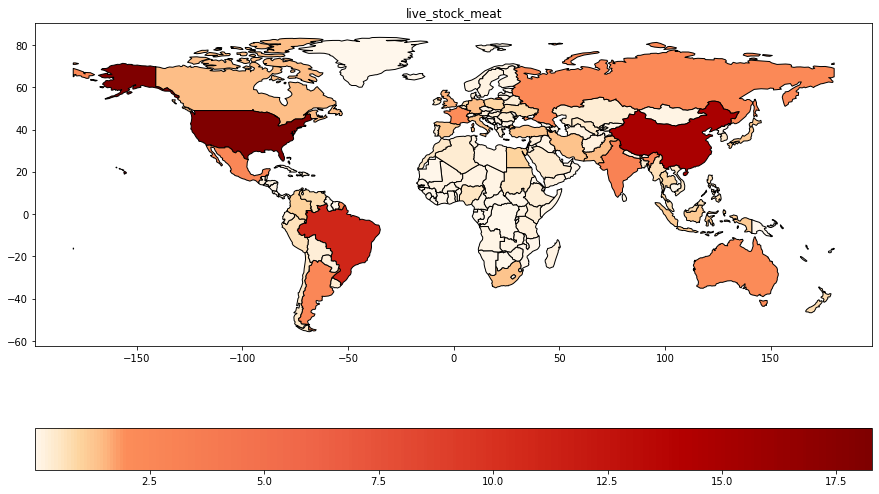

In [320]:
# World map
mapp(live_stock_meat.RecentPerc,'live_stock_meat')

# Production Value

In [321]:
# Load dataset
value_production = pd.read_csv(cl+VALUE_PROD, encoding = "ISO-8859-1")

In [322]:
value_production.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016
0,2,Afghanistan,221,"Almonds, with shell",152,Gross Production Value (constant 2004-2006 100...,1000 Int. $,NaN,NaN,NaN,...,92899.455089,123940.698000,127431.694327,165254.264000,178861.182059,182960.078000,124575.156335,80856.550600,71549.194374,96918.674867
1,2,Afghanistan,221,"Almonds, with shell",154,Net Production Value (constant 2004-2006 1000 I$),1000 Int. $,NaN,NaN,NaN,...,92899.455089,123940.698000,127431.694327,165254.264000,178861.182059,182960.078000,124575.156335,80856.550600,71549.194374,96918.674867
2,2,Afghanistan,221,"Almonds, with shell",56,Gross Production Value (current million SLC),SLC,NaN,NaN,NaN,...,5433.830473,8980.020000,8032.038000,12079.200000,13995.079900,14911.000000,9230.459191,5563.109132,4824.773367,6050.024466
3,2,Afghanistan,221,"Almonds, with shell",55,Gross Production Value (constant 2004-2006 mil...,SLC,NaN,NaN,NaN,...,3280.355179,4376.446667,4499.716581,5835.262222,6315.733546,6460.468889,4398.849906,2855.110444,2526.460140,3422.277092
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",152,Gross Production Value (constant 2004-2006 100...,1000 Int. $,NaN,NaN,NaN,...,93962.672000,49744.944000,57275.009778,56377.603200,64207.463034,69090.200000,69090.200000,73114.852434,79457.968291,77478.699955


In this case, we choose to focus on the `Net Production Value`: other data from these dataset may turn out to be useful later.

In [323]:
# Select interesting data
value_production_NET = value_production[value_production['Element']=='Net Production Value (constant 2004-2006 1000 I$)']

In [324]:
years = ['Y'+str(2000+x) for x in range(0,17)]

In [325]:
value_production_NET = clean_df(value_production_NET,years,to_drop,changes)
value_production_NET.head(10)

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,RecentPerc
Area,,,,,,,,,,,,,,,,,,,,,
China,2.856057e+08,3.004274e+08,3.216996e+08,3.495449e+08,3.810505e+08,4.078850e+08,4.147613e+08,4.136915e+08,4.160367e+08,4.378185e+08,...,2.374730e+09,2.430197e+09,2.497566e+09,2.579450e+09,2.671983e+09,2.718948e+09,2.757434e+09,2.834995e+09,2.892535e+09,22.676521
United States of America,4.788846e+08,4.833203e+08,5.044035e+08,5.105117e+08,5.229573e+08,5.244264e+08,5.486602e+08,5.581502e+08,5.603537e+08,5.526819e+08,...,1.054390e+09,1.072548e+09,1.079007e+09,1.063275e+09,1.054987e+09,1.105026e+09,1.140359e+09,1.134826e+09,1.185232e+09,10.274408
India,2.790599e+08,2.769447e+08,2.836582e+08,2.905825e+08,2.764053e+08,2.765087e+08,2.944922e+08,3.085220e+08,3.195680e+08,3.342545e+08,...,1.023588e+09,1.002839e+09,1.086385e+09,1.156100e+09,1.180723e+09,1.224943e+09,1.258375e+09,1.244288e+09,1.271248e+09,9.896566
Brazil,9.706583e+07,1.010679e+08,1.016636e+08,1.037381e+08,1.194599e+08,1.125299e+08,1.213949e+08,1.244923e+08,1.291420e+08,1.334433e+08,...,6.201563e+08,6.161184e+08,6.514611e+08,6.810545e+08,6.742665e+08,7.171909e+08,7.201512e+08,7.355686e+08,7.155045e+08,5.777904
Indonesia,4.792374e+07,5.094239e+07,4.857062e+07,5.154759e+07,5.176794e+07,5.308684e+07,5.125489e+07,5.861990e+07,5.969219e+07,6.350739e+07,...,2.633379e+08,2.775410e+08,2.848377e+08,2.923397e+08,3.139762e+08,3.170390e+08,3.234137e+08,3.308547e+08,3.324515e+08,2.541706
Russia,3.598542e+08,3.634709e+08,3.527262e+08,3.964110e+08,3.852862e+08,4.354161e+08,4.473050e+08,4.738484e+08,4.461587e+08,4.802192e+08,...,2.137860e+08,2.185227e+08,1.899717e+08,2.307741e+08,2.177522e+08,2.331347e+08,2.377972e+08,2.448214e+08,2.628094e+08,1.998335
France,1.335034e+08,1.532157e+08,1.433778e+08,1.442604e+08,1.536056e+08,1.457604e+08,1.563589e+08,1.628161e+08,1.535950e+08,1.650602e+08,...,1.945564e+08,1.974331e+08,1.950832e+08,1.987566e+08,1.951354e+08,1.943815e+08,2.041452e+08,2.030985e+08,1.871680e+08,1.946463
Argentina,6.971466e+07,7.388008e+07,8.095213e+07,7.512886e+07,7.182643e+07,7.864141e+07,8.592927e+07,8.088167e+07,8.755676e+07,8.628755e+07,...,1.963369e+08,1.663790e+08,1.908641e+08,2.007904e+08,1.848096e+08,2.013258e+08,2.081267e+08,2.196063e+08,2.204172e+08,1.785538
Pakistan,3.094832e+07,3.305376e+07,3.435364e+07,3.490031e+07,3.675264e+07,3.735661e+07,4.041752e+07,4.340816e+07,4.457554e+07,4.608498e+07,...,1.724839e+08,1.765193e+08,1.732396e+08,1.854182e+08,1.847809e+08,1.948705e+08,1.981400e+08,2.007263e+08,1.996271e+08,1.646633


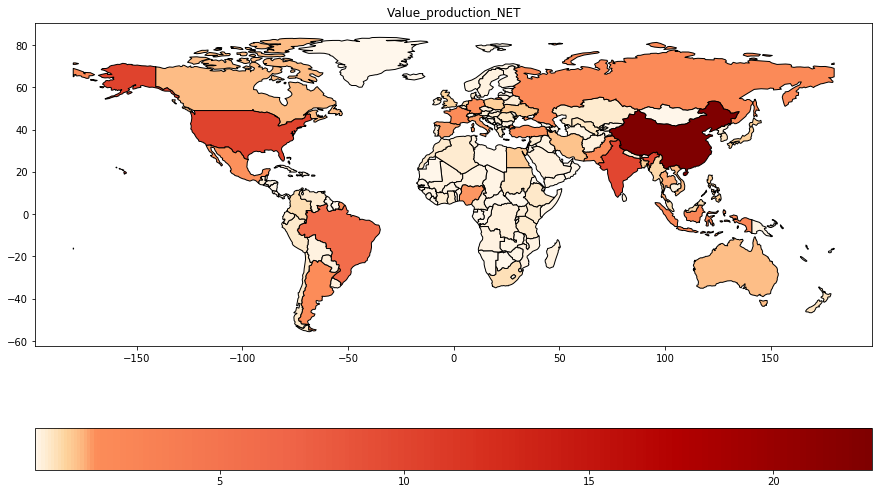

In [327]:
# World map
mapp(value_production_NET.RecentPerc,'Value_production_NET')

## Interactive Map

In this section, we decide to build interactive maps to show time and space data together in the same visualization.

In [328]:
def interactive_df(df):
    df = df.apply(norm)*100
    df.columns = df.columns.str.replace('Y', '')
    df = df.drop(['RecentPerc'], axis=1)
    df = df.stack()
    df = df.reset_index()
    df = df.rename(columns={'level_1': 'YEAR', 0: 'Total'})
    df['YEAR'] = df['YEAR'].astype(int)
    return df

In [333]:
def mapp_interactive(result, world_df=world_df):
    year = np.mean(result['YEAR'])
    result = result.drop('YEAR', axis=1)
    merged = world_df.set_index('name').join(result)
    merged = merged.dropna(subset=['Total'])
    vmin, vmax, vcenter = merged.Total.min(), merged.Total.max(), merged.Total.median()
    divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    ax = merged.plot(column='Total', figsize=(15,10), k=9, norm=divnorm, cmap='Greens', linewidth=1, edgecolor = "black",
                     legend=True, legend_kwds={'orientation': "horizontal"})
    ax.set_title(year,size=10)
    return

In [334]:
def plot_func(year):
    result = df
    result = result.set_index('Area')
    result = result[result['YEAR']==year]
    mapp_interactive(result)

### Crops interactive

In [335]:
interactive_crops = interactive_df(crops_production)
interactive_crops.head()

,Area,YEAR,Total
0,China,1961,6.366381
1,China,1962,6.464886
2,China,1963,6.579475
3,China,1964,6.593804
4,China,1965,7.120137


In [336]:
df = interactive_crops
range_year = (df['YEAR'].min(),df['YEAR'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

### Live Stock interactive

In [339]:
interactive_live_stock = interactive_df(live_stock_meat)

In [340]:
df = interactive_live_stock
range_year = (df['YEAR'].min(),df['YEAR'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

### Production value interactive

In [341]:
interactive_values = interactive_df(value_production_NET)

In [342]:
df = interactive_values
range_year = (df['YEAR'].min(),df['YEAR'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1988, description='year', max=2016, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

# Emissions
In this section we analyze the total emissions in agriculture dataset from [FAO](http://www.fao.org/faostat/en/#data/GT).

In [59]:
# Import the dataset
emissions = pd.read_csv(en+EMISSIONS,encoding = "ISO-8859-1")

In [60]:
# See how it is organized
print(emissions.columns)
emissions.head()

Index(['Area Code', 'Area', 'Item Code', 'Item', 'Element Code', 'Element',
       'Unit', 'Y1961', 'Y1962', 'Y1963', 'Y1964', 'Y1965', 'Y1966', 'Y1967',
       'Y1968', 'Y1969', 'Y1970', 'Y1971', 'Y1972', 'Y1973', 'Y1974', 'Y1975',
       'Y1976', 'Y1977', 'Y1978', 'Y1979', 'Y1980', 'Y1981', 'Y1982', 'Y1983',
       'Y1984', 'Y1985', 'Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991',
       'Y1992', 'Y1993', 'Y1994', 'Y1995', 'Y1996', 'Y1997', 'Y1998', 'Y1999',
       'Y2000', 'Y2001', 'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007',
       'Y2008', 'Y2009', 'Y2010', 'Y2011', 'Y2012', 'Y2013', 'Y2014', 'Y2015',
       'Y2016', 'Y2017', 'Y2030', 'Y2050'],
      dtype='object')


,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2030,Y2050
0,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),gigagrams,240.6831,245.3106,255.8285,...,401.0680,402.5130,396.9210,393.0930,398.2870,384.1370,381.6789,371.9253,453.7474,603.6185
1,2,Afghanistan,5058,Enteric Fermentation,7231,Emissions (CO2eq),gigagrams,5054.3459,5151.5228,5372.3989,...,8422.4280,8452.7730,8335.3410,8254.9530,8364.0270,8066.8761,8015.2578,7810.4313,9528.6962,12675.9880
2,2,Afghanistan,5058,Enteric Fermentation,7244,Emissions (CO2eq) from CH4,gigagrams,5054.3459,5151.5228,5372.3989,...,8422.4280,8452.7730,8335.3410,8254.9530,8364.0270,8066.8761,8015.2578,7810.4313,9528.6962,12675.9880
3,2,Afghanistan,5059,Manure Management,7225,Emissions (CH4),gigagrams,11.6228,11.9632,12.6064,...,26.5669,26.1599,26.0913,26.0859,26.3682,24.9017,24.7679,23.7619,27.2114,35.2700
4,2,Afghanistan,5059,Manure Management,7231,Emissions (CO2eq),gigagrams,367.8310,376.4362,392.5811,...,681.2759,678.8488,672.3300,667.6991,675.6191,645.1936,641.9611,623.3735,750.3240,1003.2279


In [61]:
# See the unique values of the interesting columns
def uniquevalues(df):
    for i in ['Item', 'Element', 'Unit']:
        print(i)
        print(df[i].unique())
uniquevalues(emissions)

Item
['Enteric Fermentation' 'Manure Management' 'Rice Cultivation'
 'Synthetic Fertilizers' 'Manure applied to Soils'
 'Manure left on Pasture' 'Crop Residues' 'Burning - Crop residues'
 'Burning - Savanna' 'Agriculture total' 'Agricultural Soils'
 'Cultivation of Organic Soils']
Element
['Emissions (CH4)' 'Emissions (CO2eq)' 'Emissions (CO2eq) from CH4'
 'Emissions (CO2eq) from N2O' 'Emissions (N2O)']
Unit
['gigagrams']


As we can see from the `Element` column, we have different emissions measurements. Among all we have the column `Emissions (CO2eq)` that is actually the sum of all the emissions converted into equivalent CO2 production. Therefore we decide to keep only these values.

In [62]:
# Keep only the CO2 equivalent values
emissions = emissions[emissions.Element=='Emissions (CO2eq)']

Considering the `Item` column, we can see that the emission production can be referred to different specific agriculture topics. We notice that we could specifically refer them to livestock or crop production. Therefore we decide to split the dataset into two different datasets.

The dataset `emissions_live_stock` contains the emssions referred to:
* 'Enteric Fermentation'
* 'Manure Management'
* 'Manure left on Pature'

The dataset `emissions_agricuture` contains the emissions referred to:
* 'Synthetic Fertilizers'
* 'Manure applied to Soils'
* 'Crop Residues'
* 'Burning - Crop residues'
* 'Burning - Savanna'
* 'Rice Cultivation'
* 'Cultivation of Organic Soils'

In [63]:
# Create the livestock emissions dataset
emissions_live_stock = emissions[(emissions.Item=='Enteric Fermentation')\
                     | (emissions.Item=='Manure Management')\
                     | (emissions.Item=='Manure left on Pasture')]

In [64]:
# Create the crops emissions dataset
emissions_crop = emissions[(emissions.Item=='Synthetic Fertilizers')\
                     | (emissions.Item=='Manure applied to Soils')\
                     | (emissions.Item=='Crop Residues')\
                     | (emissions.Item=='Burning - Crop residues')\
                     | (emissions.Item=='Burning - Savanna')\
                     | (emissions.Item=='Rice Cultivation')\
                     | (emissions.Item=='Cultivation of Organic Soils')]

As previously done for the agriculture production datasets we select only the years of interest. For this dataset we also have predictions for the emissions in 2030 and 2050. We decide to keep them as they might be useful for further analyses.

In [65]:
# Columns after 2000
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Area Code','Item Code','Element Code']

We then use the previously defined function `clean_df` that we use to clean the datasets.

In [66]:
# Clean live stock dataset
emissions_live_stock = clean_df(emissions_live_stock,years,to_drop,changes)

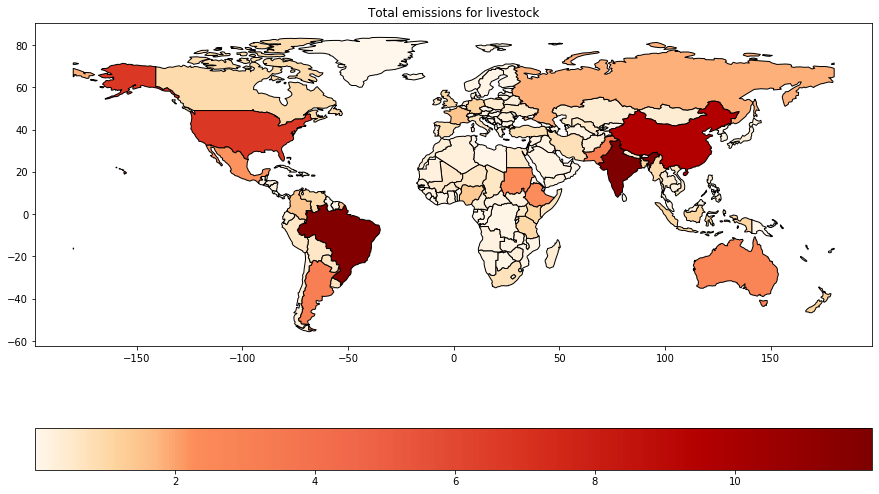

In [343]:
# World map
mapp(emissions_live_stock.Total,'Total emissions for livestock')

In [68]:
# Clean crops dataset
emissions_crop = clean_df(emissions_crop,years,to_drop,changes)

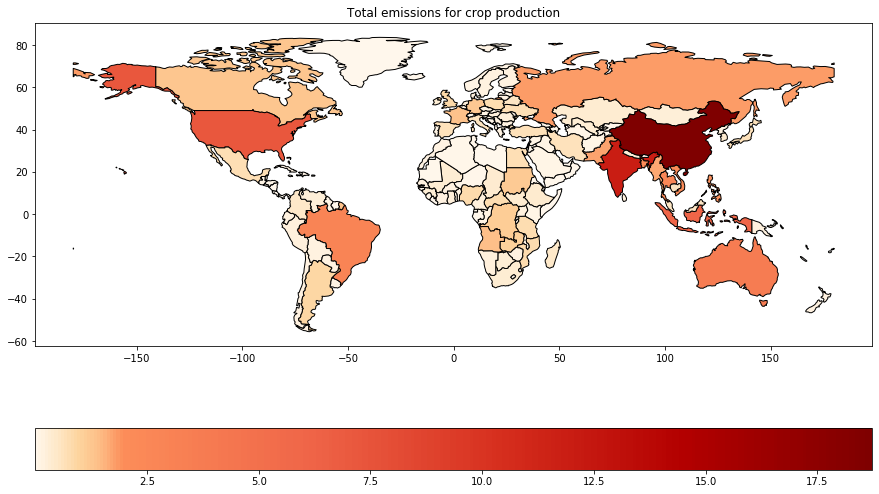

In [344]:
# World map
mapp(emissions_crop.Total, 'Total emissions for crop production')

In [70]:
# Live stock interactive map
emissions_live_stock_interactive = interactive_df(emissions_live_stock)

In [71]:
df = emissions_live_stock_interactive
range_year = (df['YEAR'].min(),df['YEAR'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=2005, description='year', max=2050, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [72]:
# Crops interactive map
emissions_crop_interactive = interactive_df(emissions_crop)

In [73]:
df = emissions_crop_interactive
range_year = (df['YEAR'].min(),2017)
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [74]:
interactive_crops = interactive_crops[(interactive_crops.YEAR>=1961) & (interactive_crops.YEAR<=2014)]
interactive_crops = interactive_crops.set_index(['Area','YEAR'])
complete = interactive_crops
complete['Crops'] = complete['Total'] 
del complete['Total']
complete = complete.reset_index()

# Fertilizers
We now consider the fertilizers use datasets. For this topic we do not have a unique dataset but we actually consider three different ones since FAO in 2002 changed the way they collected the data. Until 2002 they had a unique dataset called `fertilizers archive`, then they changed the classification methods and decided to have three different datasets:
* `fertilizers by nutrient` containing information on the totals separately for the three main plant nutrients nitrogen (N), phosphate (P2O5) and potash (K2O);
* `fertilizers by product` containing information on fertilizing products amounts;
* `fertilizers indicators` containing the use of fertilizers per area of cropland grouped into the three main plant nutrients.

In order to provide a unique dataset we have to go further in understanding how the data is organized. So let's import them and have a look.

In [75]:
# Old dataset:
FA='Inputs_FertilizersArchive_E_All_Data.csv'
# New datasets
FN = 'Inputs_FertilizersNutrient_E_All_Data_NOFLAG.csv'
FP = 'Inputs_FertilizersProduct_E_All_Data_NOFLAG.csv'
FI = 'Environment_Fertilizers_E_All_Data_NOFLAG.csv'

In [76]:
# Import the datasets
fa = pd.read_csv(en+FA, encoding = "ISO-8859-1")
fn = pd.read_csv(en+FN, encoding = "ISO-8859-1")
fp = pd.read_csv(en+FP, encoding = "ISO-8859-1")
fi = pd.read_csv(en+FI, encoding = "ISO-8859-1")

In [77]:
fa.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1961F,Y1962,...,Y1998,Y1998F,Y1999,Y1999F,Y2000,Y2000F,Y2001,Y2001F,Y2002,Y2002F
0,2,Afghanistan,1402,Ammonia,5510,Production,tonnes,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR
1,2,Afghanistan,1402,Ammonia,5610,Import Quantity,tonnes,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR
2,2,Afghanistan,1402,Ammonia,5910,Export Quantity,tonnes,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR
3,2,Afghanistan,1402,Ammonia,5157,Agricultural Use,tonnes,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR
4,2,Afghanistan,1402,Ammonia,5751,Prices Paid by Farmers,LCU/mt,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR


In [78]:
fp.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y2002,Y2003,Y2004,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,4007,"Ammonia, anhydrous",5610,Import Quantity,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,4.49,NaN,NaN,2.00,NaN,NaN,2.07
1,2,Afghanistan,4007,"Ammonia, anhydrous",5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,2.69,NaN,NaN,1.07,NaN,NaN,1.24
2,2,Afghanistan,4003,Ammonium nitrate (AN),5610,Import Quantity,tonnes,1786.13,NaN,NaN,...,NaN,NaN,NaN,NaN,1456.8,1.0,NaN,NaN,NaN,NaN
3,2,Afghanistan,4003,Ammonium nitrate (AN),5622,Import Value,1000 US$,123.24,NaN,NaN,...,NaN,NaN,NaN,NaN,445.8,2.8,NaN,NaN,NaN,NaN
4,2,Afghanistan,4002,Ammonium sulphate,5610,Import Quantity,tonnes,NaN,0.14,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN


In [79]:
fn.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y2002,Y2003,Y2004,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,tonnes,23414.00,16206.00,19458.00,...,15324.00,13606.00,12022.00,17555.00,15776.00,15694.00,14416.00,14416.00,14416.00,14416.00
1,2,Afghanistan,3102,Nutrient nitrogen N (total),5610,Import Quantity,tonnes,1132.46,4233.77,2905.48,...,4.68,1001.89,914.39,5411.94,1289.25,19223.36,59482.34,6659.57,82277.39,126363.30
2,2,Afghanistan,3102,Nutrient nitrogen N (total),5910,Export Quantity,tonnes,22.93,32.75,23.79,...,896.65,452.01,7.38,0.00,0.00,13.57,27.14,0.00,22.55,5.14
3,2,Afghanistan,3102,Nutrient nitrogen N (total),5157,Agricultural Use,tonnes,24523.53,20407.02,22339.69,...,14432.03,14155.88,12929.01,22970.63,17065.25,34903.79,73872.84,21075.57,96670.85,140775.85
4,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5510,Production,tonnes,0.00,0.00,NaN,...,NaN,NaN,NaN,1563.00,460.00,1539.00,1541.00,1541.00,1541.00,1541.00


In [80]:
fi.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y2002,Y2003,Y2004,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,kg/ha,3.16,2.58,2.82,...,1.82,1.79,1.63,2.90,2.16,4.41,9.34,2.66,12.22,17.80
1,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,kg/ha,0.00,0.84,1.36,...,0.00,0.07,0.12,0.87,0.16,0.38,0.65,1.28,1.14,2.11
2,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,kg/ha,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.01,0.00
3,3,Albania,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,kg/ha,54.67,53.47,51.67,...,41.24,48.76,44.96,53.01,50.21,44.11,44.13,52.87,60.98,56.70
4,3,Albania,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,kg/ha,26.02,28.65,31.94,...,25.81,29.96,31.08,33.54,31.85,32.90,32.91,41.27,49.10,30.77


In [81]:
def uniquevalues(df):
    for i in ['Item', 'Element', 'Unit']:
        print(i)
        print(df[i].unique())

In [82]:
uniquevalues(fa)

Item
['Ammonia' 'Ammonium nitrate (AN)' 'Ammonium Phosphat (P2o5)'
 'Ammonium Phosphate (N)' 'Ammonium sulphate' 'Ammonium SulphateNitrate'
 'Basic Slag' 'Calcium ammonium nitrate' 'Calcium Cyanamide'
 'Calcium Nitrate' 'Complex Fertilizer (K2o)' 'Concent Superphosphate'
 'Crude Salts To 20% K2o' 'Ground Rock Phosphate' 'Muriate 20-45% K2o'
 'Muriate Over 45% K2o' 'Nitrogenous fertilizers'
 'Oth Complex Fert (P2o5)' 'Other Complex Fert (N)'
 'Other nitrogenous fertilizers, n.e.c.'
 'Other phosphatic fertilizers, n.e.c.\r\n'
 'Other potassic fertilizers, n.e.c.' 'Phosphate fertilizers'
 'Potash fertilizers' 'Potassium sulphate (sulphate of potash) (SOP)'
 'Single Superphosphate' 'Sodium Nitrate' 'Urea' 'Total Fertilizers'
 'Phosphoric Acid']
Element
['Production' 'Import Quantity' 'Export Quantity' 'Agricultural Use'
 'Prices Paid by Farmers']
Unit
['tonnes' 'LCU/mt']


In [83]:
uniquevalues(fp)

Item
['Ammonia, anhydrous' 'Ammonium nitrate (AN)' 'Ammonium sulphate'
 'Calcium ammonium nitrate (CAN) and other mixtures with calcium carbonate'
 'Diammonium phosphate (DAP)' 'Fertilizers n.e.c.'
 'Monoammonium phosphate (MAP)' 'NPK fertilizers'
 'Other nitrogenous fertilizers, n.e.c.' 'Other NP compounds'
 'Other phosphatic fertilizers, n.e.c.'
 'Other potassic fertilizers, n.e.c.' 'Phosphate rock' 'PK compounds'
 'Potassium chloride (muriate of potash) (MOP)' 'Potassium nitrate'
 'Potassium sulphate (sulphate of potash) (SOP)' 'Sodium nitrate'
 'Superphosphates above 35%' 'Urea'
 'Urea and ammonium nitrate solutions (UAN)' 'Other NK compounds'
 'Superphosphates, other']
Element
['Import Quantity' 'Import Value' 'Export Quantity' 'Export Value'
 'Production' 'Agricultural Use']
Unit
['tonnes' '1000 US$']


In [84]:
uniquevalues(fn)

Item
['Nutrient nitrogen N (total)' 'Nutrient phosphate P2O5 (total)'
 'Nutrient potash K2O (total)']
Element
['Production' 'Import Quantity' 'Export Quantity' 'Agricultural Use']
Unit
['tonnes']


In [85]:
uniquevalues(fi)

Item
['Nutrient nitrogen N (total)' 'Nutrient phosphate P2O5 (total)'
 'Nutrient potash K2O (total)']
Element
['Use per area of cropland']
Unit
['kg/ha']


As previously said, for the first three dasets we are going to select only the element `Agricultural Use`. Since in the dataset `fertilizers indicators` we only have the amount of fertilizer used per cropland, we are initially not going to consider this dataset. We may will consider it later if it will be needed. 

In [86]:
fa = fa[fa.Element=='Agricultural Use']
fp = fp[fp.Element=='Agricultural Use']
fn = fn[fn.Element=='Agricultural Use']

In [87]:
# Check Unit
fa.Unit.unique(), fp.Unit.unique(), fn.Unit.unique()

(array(['tonnes'], dtype=object),
 array(['tonnes'], dtype=object),
 array(['tonnes'], dtype=object))

In [88]:
# Get the total sum from a by nutrient categorization on fertilizers archive
fa_n = fa[(fa.Item=='Nitrogenous fertilizers')\
          | (fa.Item=='Phosphate fertilizers')\
          | (fa.Item=='Potash fertilizers')]\
          .groupby('Area').sum()
fa_n.Y2002.head()

Area
Afghanistan       20800.0
Africa          4278401.0
Albania           35357.0
Algeria           98000.0
Americas       35142135.0
Name: Y2002, dtype: float64

In [89]:
# Get the total sum from a by product categorization on fertilizers archive
fa_p = fa[(fa.Item!='Nitrogenous fertilizers')\
          & (fa.Item!='Phosphate fertilizers')\
          & (fa.Item!='Potash fertilizers')\
          & (fa.Item!='Total Fertilizers') ]\
          .groupby(['Area']).sum()
fa_p.Y2002.head()

Area
Afghanistan         20800.0
Africa            3567481.0
Albania             35357.0
Algeria                 0.0
American Samoa          0.0
Name: Y2002, dtype: float64

As we can see we now found how the dataset `fertilizers archive` categorizes the data. It seems that we could obtain the same total amount of fertilizer used from the two methods (by nutrient or by product) but still information is lacking from the categorization by product. From the `fertilizers archive` dataset we therefore decide to keep only the total amount of fertilizers used yearly for each country by keeping only the items `Total Fertilizers`.

Concerning the `fertilizers by nutrient` dataset we read from the [FAO website](http://fenixservices.fao.org/faostat/static/documents/RFN/RFN_EN_README.pdf) that the nutrients are calculated by also taking into account the compound fertilizers that, however, are not considered in the `fertilizers archive`.
This explains why we obtain results that are close but still different from the two totals of the two datasets.

Since in our analysis we are now interested in percentages rather than precise values of fertilizers use, from now on we are going to consider the `fertilizers by nutrient` for the years from 2002 on and the `Total Fertilizers` items from the `fertilizeers archive` for years before 2002.

We are now goint to put them together but first we need to drop the `Flag` columns (that say how data was calculated) from the `fertilizers archive`.

In [90]:
# Drop the flag years and the year 2002 from fertilizers archive
years_drop = ['Y'+str(1900+x)+'F' for x in range(61,100)] + ['Y'+str(2000+x)+'F' for x in range(0,3)]+['Y2002']
fa = fa.drop(years_drop, axis=1)

In [91]:
# Filter only the Total Fertilizers items
fa = fa[fa.Item=='Total Fertilizers']
fa = fa.replace(changes)
fa.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,Y2000,Y2001
143,2,Afghanistan,1818,Total Fertilizers,5157,Agricultural Use,tonnes,1100.0,1100.0,1100.0,...,45800.0,40000.0,0.0,0.0,5000.0,5000.0,7000.0,5000.0,5000.0,18400.0
293,3,Albania,1818,Total Fertilizers,5157,Agricultural Use,tonnes,6302.0,5200.0,5300.0,...,23500.0,17890.0,14770.0,11000.0,6500.0,5200.0,25000.0,10600.0,18700.0,18700.0
443,4,Algeria,1818,Total Fertilizers,5157,Agricultural Use,tonnes,49000.0,55000.0,53000.0,...,96800.0,130900.0,119300.0,46400.0,38000.0,97000.0,108000.0,93000.0,92300.0,105300.0
603,7,Angola,1818,Total Fertilizers,5157,Agricultural Use,tonnes,1000.0,1000.0,1400.0,...,9100.0,8000.0,10000.0,8000.0,6000.0,2000.0,3400.0,3400.0,1400.0,0.0
758,9,Argentina,1818,Total Fertilizers,5157,Agricultural Use,tonnes,16241.0,12711.0,21080.0,...,248200.0,293900.0,462000.0,524700.0,855200.0,809600.0,775500.0,823500.0,862983.0,861991.0


In [92]:
# Calculate the total use on the fertilizers by nutrient dataset
fn = fn.replace(changes)
fn = fn.groupby(['Area']).sum().drop(['Area Code','Item Code','Element Code'], axis=1)
fn.head()

,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,
Afghanistan,24526.53,27035.26,33169.37,29774.39,24869.52,16377.29,14432.03,14712.11,13854.86,29816.20,18523.47,38011.93,79000.86,31232.39,105733.85,157464.02
Africa,4117961.79,4526013.11,4694822.50,4502916.67,4395095.09,4422820.77,5042626.73,4391993.97,5507875.99,5234137.06,5442198.67,5565927.83,5962381.02,5670156.19,5942546.50,6503404.15
Albania,56404.00,57406.71,58555.64,60457.92,50108.64,51106.74,47158.94,55040.42,53224.98,60604.12,57614.41,54410.38,54410.30,66327.00,78243.70,61082.86
Algeria,72765.00,45031.00,188038.00,55806.00,99072.00,111748.00,64231.00,107000.00,118500.00,118300.00,160100.00,168300.00,190500.00,175600.00,155700.00,155700.00
Americas,35120342.52,38073447.14,40713476.39,37527532.77,38521459.24,42447632.31,38469890.76,33291895.38,39107790.21,44887837.66,45047835.97,47188778.26,47690069.87,44500444.18,47394970.46,50227671.05


In [93]:
# Create a unique dataset
fertilizers = fa.set_index('Area').join(fn)

In [94]:
fertilizers.head()

,Area Code,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,Y1964,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2,1818,Total Fertilizers,5157,Agricultural Use,tonnes,1100.0,1100.0,1100.0,1100.0,...,14432.03,14712.11,13854.86,29816.20,18523.47,38011.93,79000.86,31232.39,105733.85,157464.02
Africa,5100,1818,Total Fertilizers,5157,Agricultural Use,tonnes,716141.0,780262.0,879628.0,996966.0,...,5042626.73,4391993.97,5507875.99,5234137.06,5442198.67,5565927.83,5962381.02,5670156.19,5942546.50,6503404.15
Albania,3,1818,Total Fertilizers,5157,Agricultural Use,tonnes,6302.0,5200.0,5300.0,6400.0,...,47158.94,55040.42,53224.98,60604.12,57614.41,54410.38,54410.30,66327.00,78243.70,61082.86
Algeria,4,1818,Total Fertilizers,5157,Agricultural Use,tonnes,49000.0,55000.0,53000.0,52500.0,...,64231.00,107000.00,118500.00,118300.00,160100.00,168300.00,190500.00,175600.00,155700.00,155700.00
Americas,5200,1818,Total Fertilizers,5157,Agricultural Use,tonnes,9027226.0,10161226.0,11335980.0,11908846.0,...,38469890.76,33291895.38,39107790.21,44887837.66,45047835.97,47188778.26,47690069.87,44500444.18,47394970.46,50227671.05


In [95]:
# Years after 2000
years = ['Y'+str(2000+x) for x in range(0,17)]

We then use the previously defined function `clean_df` that we use to clean the datasets.

In [96]:
# Clean dataset
fertilizers = clean_df(fertilizers,years,to_drop,changes)
fertilizers.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Total
Area,,,,,,,,,,,,,,,,,,,,,
China,728000.0,989600.0,1247000.0,1677000.0,2604000.0,3719000.0,2697000.0,2696000.0,3474000.0,4407000.0,...,47015712.03,51511621.90,53182047.83,54078095.65,53779194.72,55618943.32,54558935.73,53724192.41,52995366.31,28.248659
India,338300.0,452200.0,543900.0,773200.0,784600.0,1100600.0,1539000.0,1760700.0,1982000.0,2256600.0,...,26445526.00,28110244.00,28373686.00,25536100.00,24482500.00,25581400.00,26752600.00,25949900.00,26593400.00,13.567807
United States of America,7646496.0,8604260.0,9474315.0,9953907.0,11276278.0,12676548.0,13645012.0,14074587.0,14577261.0,15535480.0,...,17137601.00,18262765.00,20070761.00,20565302.10,20994055.00,20660881.00,20211336.00,20544035.00,20459267.00,11.992508
Brazil,270004.0,256082.0,297782.0,247651.0,278878.0,276059.0,447925.0,601709.0,630384.0,1001917.0,...,7540435.57,10424767.72,13081009.13,12116475.02,14147326.89,15363337.57,12809826.43,14523279.55,16582859.11,6.310013
Indonesia,135990.0,149396.0,130000.0,96242.0,94498.0,145004.0,126700.0,271408.0,178007.0,240193.0,...,4286696.00,4283793.00,4662837.00,5203810.20,5159718.30,5460675.20,5443037.13,5444238.66,5824967.75,2.391433


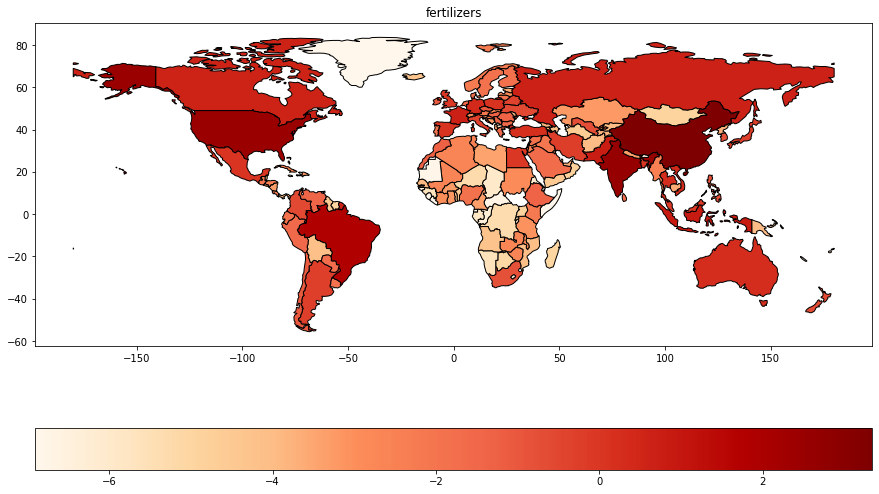

In [97]:
# World map
mapp(fertilizers.Total, 'fertilizers')

In [98]:
# Interactive map
fertilizers_interactive = interactive_df(fertilizers)

In [99]:
df = fertilizers_interactive
range_year = (df['YEAR'].min(),df['YEAR'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

# Pesticides

In [100]:
# Load dataset
pesticides = pd.read_csv(en+PESTICIDES, encoding = "ISO-8859-1")
pesticides.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1990,Y1991,Y1992,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,3,Albania,1357,Pesticides (total),5157,Agricultural Use,tonnes,121.0,121.0,121.0,...,392.6,403.49,582.93,574.62,353.05,441.53,447.89,590.41,656.52,681.14
1,3,Albania,1309,Insecticides,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,213.88,375.80,317.07,157.57,214.13,34.48,184.59,226.30,237.59
2,3,Albania,1310,Insecticides  Chlorinated Hydrocarbons,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Albania,1311,Insecticides  Organo-phosphates,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,Albania,1312,Insecticides  Carbamates,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To have a general idea on the use of pesticides, we focus on the their total amount.

In [101]:
pesticides = pesticides[pesticides.Item=='Pesticides (total)']

In [102]:
# Clean dataset
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Area Code','Item Code','Element Code']
pesticides = clean_df(pesticides,years,to_drop,changes)
pesticides.head()

,Y1990,Y1991,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Total
Area,,,,,,,,,,,,,,,,,,,,,
China,775408.37,775388.37,809244.37,854860.37,988608.37,1097075.37,1150843.77,1204908.17,1240708.57,1333139.97,...,1717687.15,1765944.22,1795371.35,1815505.77,1811604.85,1815732.79,1772420.36,1772588.89,1773634.40,43.678972
United States of America,400975.93,384646.39,400975.90,391903.86,425922.68,423201.53,433180.36,434540.76,424562.11,433633.96,...,358337.70,374818.20,391298.70,407779.20,407779.20,407779.20,407779.20,407779.20,407779.20,11.072901
Brazil,49695.00,58349.44,67003.89,75658.33,84312.78,92967.22,101621.67,110276.11,118930.56,127585.00,...,335742.00,342580.00,345026.00,346583.00,367778.00,352336.00,395646.00,377176.00,377176.00,7.618887
Argentina,26156.00,26156.00,26156.00,26156.00,30195.00,37842.00,54595.00,77691.00,62397.00,73152.15,...,138831.47,234430.38,219255.93,215405.95,211555.98,207706.00,203806.98,199907.95,196008.93,4.483995
France,97701.00,103434.00,85249.00,91953.00,89515.00,84011.00,97890.00,109793.00,107754.00,114696.00,...,63692.00,61911.00,61039.00,63547.59,66497.29,74909.60,66531.02,71951.22,70588.70,2.069175


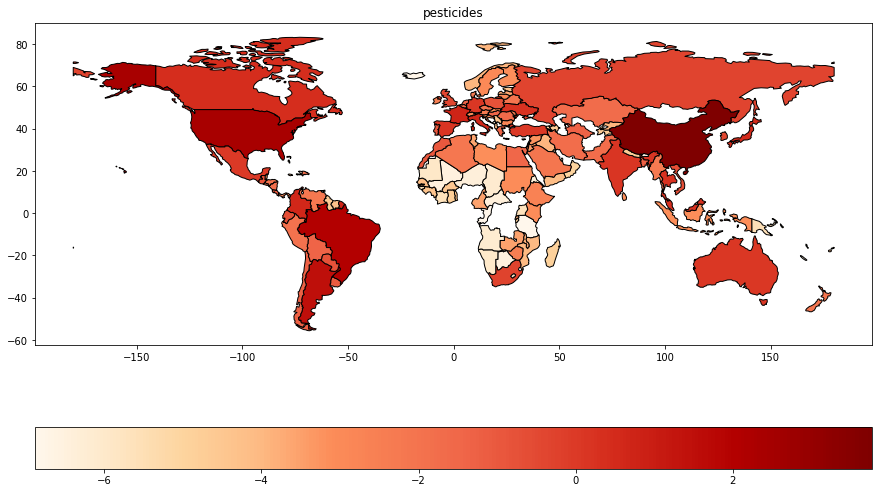

In [103]:
# World map
mapp(pesticides.Total,'pesticides')

In [104]:
# Interactive map
pesticides_interactive = interactive_df(pesticides)

In [105]:
df = pesticides_interactive
range_year = (df['YEAR'].min(),df['YEAR'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=2003, description='year', max=2017, min=1990), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

# International Trade

In [106]:
# Load dataset
trade = pd.read_csv(cl+TRADE, encoding = "ISO-8859-1")
trade.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,167.0,181.0,845.0,102.0
1,2,Afghanistan,231,Almonds shelled,5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1116.0,1377.0,4988.0,758.0
2,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,tonnes,0.0,0.0,0.0,...,2917.0,4763.0,1308.0,2262.0,1125.0,2381.0,2716.0,2342.0,1691.0,3335.0
3,2,Afghanistan,231,Almonds shelled,5922,Export Value,1000 US$,0.0,0.0,0.0,...,14784.0,35476.0,15893.0,20270.0,9647.0,18617.0,16453.0,17808.0,11954.0,23248.0
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",5610,Import Quantity,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,284.0,1000.0,815.0,38.0


In the `trade` dataset, we have import and export quantities and values for a number of different `Item` i.e. vegetables and fruits. We focus on the value only, and divide the data into two dataframe, `trade_import` and `trade_export`.

In [107]:
trade_import = trade[trade.Element=='Import Value']
trade_import.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
1,2,Afghanistan,231,Almonds shelled,5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1116.0,1377.0,4988.0,758.0
5,2,Afghanistan,711,"Anise, badian, fennel, coriander",5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,599.0,2041.0,1669.0,97.0
9,2,Afghanistan,515,Apples,5622,Import Value,1000 US$,0.0,0.0,0.0,...,131.0,553.0,9743.0,990.0,500.0,166.0,20129.0,800.0,31173.0,88287.0
13,2,Afghanistan,526,Apricots,5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
17,2,Afghanistan,527,"Apricots, dry",5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,40.0,9.0


In [108]:
trade_export = trade[trade.Element=='Export Value']
trade_export.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
3,2,Afghanistan,231,Almonds shelled,5922,Export Value,1000 US$,0.0,0.0,0.0,...,14784.0,35476.0,15893.0,20270.0,9647.0,18617.0,16453.0,17808.0,11954.0,23248.0
7,2,Afghanistan,711,"Anise, badian, fennel, coriander",5922,Export Value,1000 US$,NaN,NaN,NaN,...,1843.0,6888.0,8771.0,4428.0,4511.0,8133.0,70841.0,37709.0,26898.0,16002.0
11,2,Afghanistan,515,Apples,5922,Export Value,1000 US$,0.0,0.0,0.0,...,3664.0,4683.0,719.0,1201.0,7689.0,10387.0,4750.0,15918.0,25788.0,15087.0
15,2,Afghanistan,526,Apricots,5922,Export Value,1000 US$,0.0,0.0,0.0,...,3330.0,10915.0,2455.0,1793.0,1584.0,3678.0,5885.0,4437.0,6536.0,7069.0
19,2,Afghanistan,527,"Apricots, dry",5922,Export Value,1000 US$,0.0,0.0,0.0,...,9671.0,6331.0,9982.0,8193.0,9357.0,16365.0,11092.0,11403.0,6454.0,20664.0


In [109]:
# Years after 2000
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Area Code','Item Code','Element Code']

In [110]:
# Clean dataset
trade_import = clean_df(trade_import,years,to_drop,changes)
trade_import.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Total
Area,,,,,,,,,,,,,,,,,,,,,
United States of America,34350327.0,38048690.0,39975076.0,42105950.0,44662444.0,51927292.0,53437229.0,63323012.0,66286056.0,74624337.0,...,2.007520e+09,2.424214e+09,2.810473e+09,2.873631e+09,2.908905e+09,3.004108e+09,2.951569e+09,2.887933e+09,3.080593e+09,13.175749
China,9278141.0,8878118.0,10267239.0,11620884.0,12128120.0,12491384.0,11899955.0,12301256.0,12815066.0,15497627.0,...,1.915940e+09,2.599064e+09,3.194932e+09,3.387847e+09,3.646094e+09,3.681465e+09,3.263385e+09,3.139316e+09,3.553236e+09,11.152949
Germany,35056349.0,40202873.0,38839170.0,42502955.0,48751312.0,50890248.0,48922217.0,52735266.0,61852098.0,73349283.0,...,1.327812e+09,1.471213e+09,1.768899e+09,1.652727e+09,1.693962e+09,1.718589e+09,1.500279e+09,1.513120e+09,1.659564e+09,7.229162
Japan,15304081.0,14844554.0,18509364.0,21620855.0,22500812.0,25588482.0,28198728.0,29872383.0,33501800.0,40412351.0,...,8.292606e+08,1.007322e+09,1.251420e+09,1.271054e+09,1.189210e+09,1.153917e+09,9.572858e+08,9.130890e+08,1.002103e+09,5.066355
United Kingdom,42184782.0,42861046.0,45907029.0,49526667.0,48901322.0,49405499.0,49853300.0,49111346.0,51094461.0,54271485.0,...,8.040802e+08,8.861535e+08,1.006678e+09,1.026103e+09,1.006593e+09,1.037908e+09,9.427116e+08,9.349452e+08,9.563493e+08,4.699761


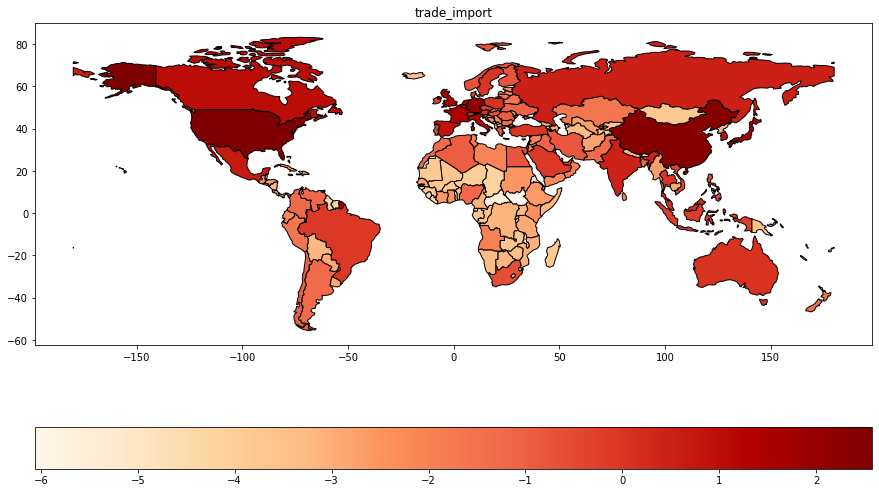

In [111]:
# World map
mapp(trade_import.Total,'trade_import')

In [112]:
# Interactive map
trade_import_interactive = interactive_df(trade_import)

In [113]:
df = trade_import_interactive
range_year = (df['YEAR'].min(),df['YEAR'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [114]:
# Clean dataset
trade_export = clean_df(trade_export,years,to_drop,changes)
trade_export.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Total
Area,,,,,,,,,,,,,,,,,,,,,
China,4731012.0,5593461.0,7182298.0,9006203.0,9907298.0,11439621.0,11476758.0,12027753.0,12726725.0,13125773.0,...,1.916457e+09,2.474428e+09,2.925815e+09,3.112072e+09,3.336794e+09,3.490578e+09,3.376000e+09,3.220122e+09,3.475108e+09,11.177904
United States of America,49200256.0,50044979.0,54591276.0,62318665.0,62556072.0,69851904.0,67727447.0,69759599.0,71635628.0,83720694.0,...,1.614930e+09,1.938263e+09,2.269106e+09,2.345853e+09,2.399544e+09,2.475761e+09,2.250806e+09,2.210338e+09,2.329894e+09,9.891513
Germany,17000413.0,17721071.0,19629179.0,21956869.0,24120047.0,26831442.0,29341768.0,33581002.0,38939679.0,46026108.0,...,1.482401e+09,1.638626e+09,1.928845e+09,1.853822e+09,1.931706e+09,1.976359e+09,1.732489e+09,1.747123e+09,1.893401e+09,8.241468
France,14210493.0,14165218.0,16258398.0,18335889.0,20414391.0,22101849.0,22636638.0,26192508.0,31276342.0,34668471.0,...,8.044931e+08,8.659928e+08,1.010100e+09,9.572109e+08,9.944633e+08,9.769490e+08,8.459655e+08,8.284999e+08,8.817310e+08,4.708771
Netherlands,11703040.0,12541041.0,13752984.0,15480034.0,17371209.0,17781139.0,19311643.0,22281698.0,25819337.0,30386544.0,...,8.921024e+08,9.852235e+08,1.142481e+09,1.112328e+09,1.154604e+09,1.130378e+09,9.657636e+08,9.935596e+08,1.165188e+09,4.696653


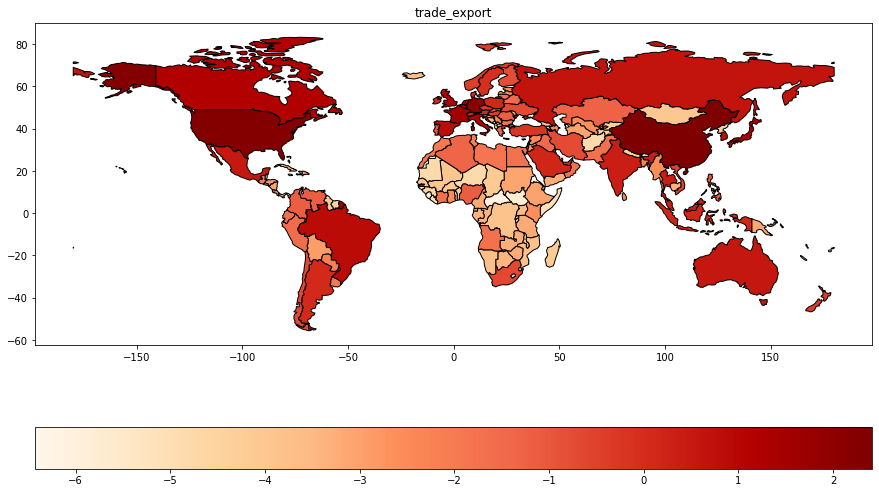

In [115]:
# World map
mapp(trade_export.Total,'trade_export')

In [116]:
# Interactive map
trade_export_interactive = interactive_df(trade_export)

In [117]:
df = trade_export_interactive
range_year = (df['YEAR'].min(),df['YEAR'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

# Land Use

In [118]:
# Load dataset
land_use = pd.read_csv(er+LAND, encoding='latin-1')
land_use.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,6600,Country area,5110,Area,1000 ha,65286.0,65286.0,65286.0,...,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0
1,2,Afghanistan,6601,Land area,5110,Area,1000 ha,65286.0,65286.0,65286.0,...,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0
2,2,Afghanistan,6602,Agriculture,5110,Area,1000 ha,37700.0,37760.0,37810.0,...,37910.0,37910.0,37911.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0
3,2,Afghanistan,6610,Agricultural land,5110,Area,1000 ha,37700.0,37760.0,37810.0,...,37910.0,37910.0,37911.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0
4,2,Afghanistan,6620,Cropland,5110,Area,1000 ha,7700.0,7760.0,7810.0,...,7910.0,7910.0,7911.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0


In [119]:
land_use['Element'].value_counts()

Area                              5558
Carbon stock in living biomass     271
Name: Element, dtype: int64

We consider only the `Area` element of the dataset.

In [120]:
land_use = land_use[land_use.Element=='Area']

In [121]:
# Check unit
land_use['Unit'].value_counts()

1000 ha    5558
Name: Unit, dtype: int64

In [122]:
land_use = land_use.drop(columns=['Unit','Element','Element Code'])

In [123]:
# Fix countries names
land_use = land_use.replace(changes)
land_use.head()

,Area Code,Area,Item Code,Item,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,6600,Country area,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,...,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0
1,2,Afghanistan,6601,Land area,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,...,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0
2,2,Afghanistan,6602,Agriculture,37700.0,37760.0,37810.0,37873.0,37875.0,37913.0,...,37910.0,37910.0,37911.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0
3,2,Afghanistan,6610,Agricultural land,37700.0,37760.0,37810.0,37873.0,37875.0,37913.0,...,37910.0,37910.0,37911.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0
4,2,Afghanistan,6620,Cropland,7700.0,7760.0,7810.0,7873.0,7875.0,7913.0,...,7910.0,7910.0,7911.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0


In [124]:
# Filter countries
land_use = land_use.loc[land_use.Area.map(lambda x: x in countries),:]
land_use.head()

,Area Code,Area,Item Code,Item,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,6600,Country area,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,...,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0
1,2,Afghanistan,6601,Land area,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,...,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0
2,2,Afghanistan,6602,Agriculture,37700.0,37760.0,37810.0,37873.0,37875.0,37913.0,...,37910.0,37910.0,37911.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0
3,2,Afghanistan,6610,Agricultural land,37700.0,37760.0,37810.0,37873.0,37875.0,37913.0,...,37910.0,37910.0,37911.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0
4,2,Afghanistan,6620,Cropland,7700.0,7760.0,7810.0,7873.0,7875.0,7913.0,...,7910.0,7910.0,7911.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0


In [125]:
# Keep only recent years
years = ['Y'+str(1900+x) for x in range(61,100)]
land_use = land_use.drop(columns=years)
land_use.head()

,Area Code,Area,Item Code,Item,Y2000,Y2001,Y2002,Y2003,Y2004,Y2005,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,6600,Country area,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,...,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0
1,2,Afghanistan,6601,Land area,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,...,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0
2,2,Afghanistan,6602,Agriculture,37753.0,37753.0,37753.0,37910.0,37911.0,37910.0,...,37910.0,37910.0,37911.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0
3,2,Afghanistan,6610,Agricultural land,37753.0,37753.0,37753.0,37910.0,37911.0,37910.0,...,37910.0,37910.0,37911.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0
4,2,Afghanistan,6620,Cropland,7753.0,7753.0,7753.0,7910.0,7911.0,7910.0,...,7910.0,7910.0,7911.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0


In [126]:
# Have a look at which Items do we have in the dataset
items = land_use[['Area','Item Code','Item']].groupby(['Item Code','Item']).count()
items[items.Area > 50].sort_values('Item Code').head(10)

,,Area
Item Code,Item,
6600,Country area,169
6601,Land area,169
6602,Agriculture,171
6610,Agricultural land,171
6611,Agriculture area actually irrigated,102
6620,Cropland,170
6621,Arable land,169
6630,Land under temporary crops,89
6633,Land under temp. meadows and pastures,52


In [127]:
item_code_list = set([6600, 6601, 6680, 6610, 6620, 6630, 6650, 6621, 6633, 6655, 6646, 6714, 6716, 6717])

In [128]:
land_use = land_use.loc[land_use['Item Code'].map(lambda x: x in item_code_list),:]

In [129]:
changes_item = {'Item' : {'Land under permanent crops' : 'Crops' ,
                    'Land under temporary crops' : 'Crops',
                    'Land under perm. meadows and pastures' : 'Meadows',
                    'Land under temp. meadows and pastures' : 'Meadows',
                    'Other naturally regenerated forest' : 'Other forest'
                    }}

In [130]:
land_use = land_use.replace(changes_item)
land_use = land_use.groupby(['Area','Item']).sum().drop(columns=['Area Code','Item Code'])
land_use.head(10)

Y2000    Y2001    Y2002    Y2003    Y2004  \
Area        Item                                                             
Afghanistan Agricultural land  37753.0  37753.0  37753.0  37910.0  37911.0   
            Arable land         7683.0   7683.0   7678.0   7772.0   7816.0   
            Country area       65286.0  65286.0  65286.0  65286.0  65286.0   
            Cropland            7753.0   7753.0   7753.0   7910.0   7911.0   
            Crops                 70.0   2572.0   2186.0   3899.0   3029.0   
            Forest land         1350.0   1350.0   1350.0   1350.0   1350.0   
            Land area          65286.0  65286.0  65286.0  65286.0  65286.0   
            Meadows            30000.0  30000.0  30000.0  30000.0  30000.0   
            Other forest        1350.0   1350.0   1350.0   1350.0   1350.0   
            Planted Forest         0.0      0.0      0.0      0.0      0.0   

                                 Y2005    Y2006    Y2007    Y2008    Y2009  \
Area        Item                                                             
Afghanistan Agricultural land  37910.0  37910.0  37910.0  37910.0  37910.0   
            Arable land         7805.0   7794.0   7794.0   7794.0   7793.0   
            Country area       65286.0  65286.0  65286.0  65286.0  65286.0   
            Cropland            7910.0   7910.0   7910.0   7910.0   7910.0   
            Crops               3490.0   3645.0   3647.0   3340.0   3586.0   
            Forest land         1350.0   1350.0   1350.0   1350.0   1350.0   
            Land area          65286.0  65286.0  65286.0  65286.0  65286.0   
            Meadows            30000.0  30000.0  30000.0  30000.0  30000.0   
            Other forest        1350.0   1350.0   1350.0   1350.0   1350.0   
            Planted Forest         0.0      0.0      0.0      0.0      0.0   

                                 Y2010    Y2011    Y2012    Y2013    Y2014  \
Area        Item                                                             
Afghanistan Agricultural land  37911.0  37910.0  37910.0  37910.0  37910.0   
            Arable land         7793.0   7791.0   7790.0   7785.0   7771.0   
            Country area       65286.0  65286.0  65286.0  65286.0  65286.0   
            Cropland            7911.0   7910.0   7910.0   7910.0   7910.0   
            Crops               3599.0   3200.0   3574.0   3616.0   3624.0   
            Forest land         1350.0   1350.0   1350.0   1350.0   1350.0   
            Land area          65286.0  65286.0  65286.0  65286.0  65286.0   
            Meadows            30000.0  30000.0  30000.0  30000.0  30000.0   
            Other forest        1350.0   1350.0   1350.0   1350.0   1350.0   
            Planted Forest         0.0      0.0      0.0      0.0      0.0   

                                 Y2015    Y2016    Y2017  
Area        Item                                          
Afghanistan Agricultural land  37910.0  37910.0  37910.0  
            Arable land         7765.0   7729.0   7699.0  
            Country area       65286.0  65286.0  65286.0  
            Cropland            7910.0   7910.0   7910.0  
            Crops               3500.0   3600.0   3083.0  
            Forest land         1350.0   1350.0   1350.0  
            Land area          65286.0  65286.0  65286.0  
            Meadows            30000.0  30000.0  30000.0  
            Other forest        1350.0   1350.0   1350.0  
            Planted Forest         0.0      0.0      0.0

In [131]:
land_use['AVG'] = land_use.mean(axis = 1)

In [132]:
land_use_pivot = land_use.AVG.unstack(level='Item')
land_use_pivot.head()

Item,Agricultural land,Arable land,Country area,Cropland,Crops,Forest land,Inland waters,Land area,Meadows,Other forest,Planted Forest,Primary Forest
Area,,,,,,,,,,,,
Afghanistan,37883.944444,7763.055556,65286.0,7883.944444,3181.111111,1350.000000,NaN,65286.0,30000.000000,1350.000000,0.000000,0.0
Albania,1158.592833,597.283333,2875.0,695.611111,211.916667,775.494444,118.033333,2740.0,577.031722,596.238889,94.455556,84.8
Algeria,41030.173611,7501.883728,238174.0,8362.890339,4774.228183,1765.944444,NaN,238174.0,32667.291100,1312.888889,453.055556,0.0
Angola,58242.777778,3950.000000,124670.0,4242.777778,292.777778,58688.000000,NaN,124670.0,54000.000000,58559.000000,129.000000,0.0
Argentina,141725.388889,34969.944444,278040.0,35969.944444,26355.333333,29169.444444,4371.000000,273669.0,109622.500000,26262.666667,1168.777778,1738.0


In [133]:
land_use_general = land_use_pivot[['Country area','Land area','Inland waters']]
land_use_general['Agriculture'] = land_use_pivot['Agricultural land']/land_use_pivot['Land area']*100
land_use_general['Forestry'] = land_use_pivot['Forest land']/land_use_pivot['Land area']*100

C:\Users\Claudio\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Claudio\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [134]:
land_use_general.head(10)

Item,Country area,Land area,Inland waters,Agriculture,Forestry
Area,,,,,
Afghanistan,65286.0,65286.000000,NaN,58.027670,2.067825
Albania,2875.0,2740.000000,118.033333,42.284410,28.302717
Algeria,238174.0,238174.000000,NaN,17.226974,0.741451
Angola,124670.0,124670.000000,NaN,46.717557,47.074677
Argentina,278040.0,273669.000000,4371.000000,51.787155,10.658659
Armenia,2974.0,2847.000000,127.000000,56.804043,11.657495
Australia,774122.0,768338.000000,5784.000000,51.717665,16.374000
Austria,8387.9,8256.127778,131.772222,33.908329,46.708741
Azerbaijan,8660.0,8264.527778,395.544444,57.601664,11.925061


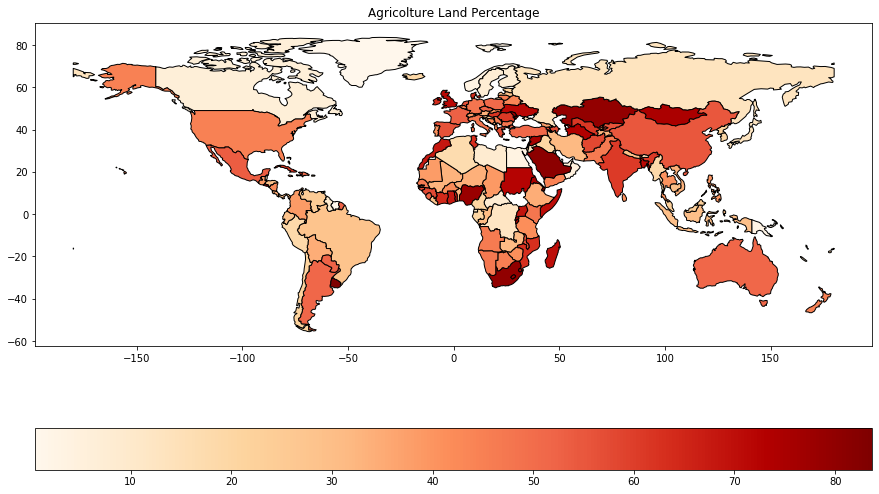

In [135]:
mapp(land_use_general.Agriculture,'Agricolture Land Percentage',log=False)

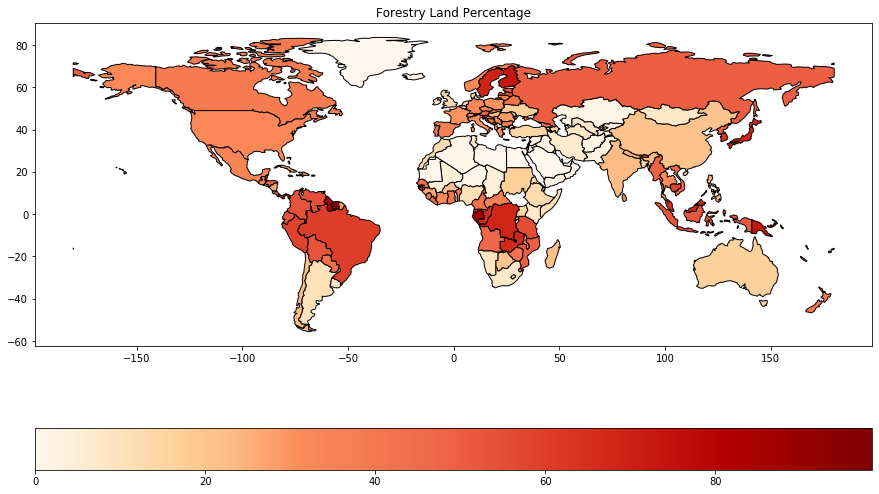

In [136]:
mapp(land_use_general.Forestry,'Forestry Land Percentage',log=False)

## Soil Quality

In [137]:
soil = pd.read_csv(er+SOIL, encoding='latin-1')
soil.head()

,CountryCode,Country,ItemCode,Item,ElementGroup,ElementCode,Element,Year,Unit,Value,Flag
0,2,Afghanistan,6709,Soil,7219,7219,Average soil erosion expressed in GLASOD erosi...,1991,degrees,0.22,NaN
1,2,Afghanistan,6709,Soil,7220,7220,Average land degradation in GLASOD erosion degree,1991,degrees,2.64,NaN
2,2,Afghanistan,6709,Soil,7221,7221,Average carbon content in the topsoil as a % i...,2008,%,0.92,NaN
3,5100,Africa + (Total),6709,Soil,7219,7219,Average soil erosion expressed in GLASOD erosi...,1991,degrees,0.89,A
4,5100,Africa + (Total),6709,Soil,7220,7220,Average land degradation in GLASOD erosion degree,1991,degrees,2.10,A


In [138]:
soil.Element.value_counts()

Average carbon content in the topsoil as a % in weight     235
Average land degradation in GLASOD erosion degree          185
Average soil erosion expressed in GLASOD erosion degree    175
Name: Element, dtype: int64

In [139]:
soil = soil.rename(columns={'Country':'Area'})

In [140]:
soil_carbon = soil[soil.ElementCode==7221]
soil_carbon = soil_carbon.drop(columns=['CountryCode','ItemCode','Item','ElementGroup','ElementCode','Element','Unit','Flag'])
soil_carbon = soil_carbon.replace(changes)
soil_carbon = soil_carbon.loc[soil_carbon.Area.map(lambda x: x in countries),:]
soil_carbon = soil_carbon.set_index(['Area'])
soil_carbon.head()

,Year,Value
Area,,
Afghanistan,2008,0.92
Albania,2008,1.24
Algeria,2008,0.81
Angola,2008,0.65
Argentina,2008,1.48


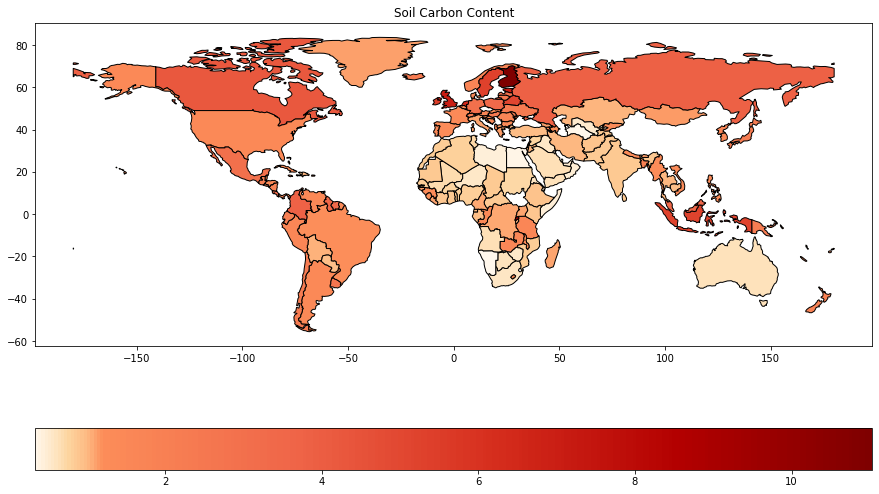

In [141]:
mapp(soil_carbon.Value,'Soil Carbon Content',log=False)

In [142]:
soil_deg = soil[soil.ElementCode==7220]
soil_deg = soil_deg.drop(columns=['CountryCode','ItemCode','Item','ElementGroup','ElementCode','Element','Unit','Flag'])
soil_deg = soil_deg.replace(changes)
soil_deg = soil_deg.loc[soil_deg.Area.map(lambda x: x in countries),:]
soil_deg = soil_deg.set_index(['Area'])
soil_deg.head()

,Year,Value
Area,,
Afghanistan,1991,2.64
Albania,1991,3.65
Algeria,1991,0.64
Angola,1991,1.21
Argentina,1991,2.60


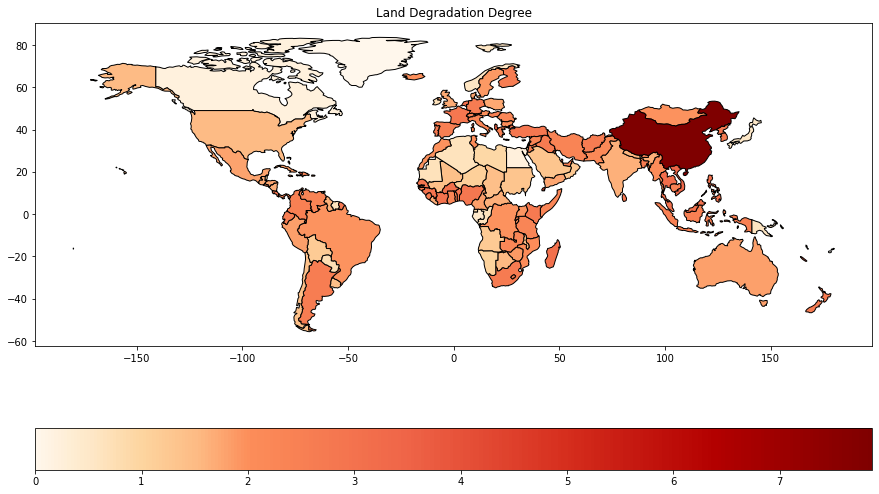

In [143]:
mapp(soil_deg.Value,'Land Degradation Degree',log=False)

In [144]:
soil_ers = soil[soil.ElementCode==7220]
soil_ers = soil_ers.drop(columns=['CountryCode','ItemCode','Item','ElementGroup','ElementCode','Element','Unit','Flag'])
soil_ers = soil_ers.replace(changes)
soil_ers = soil_ers.loc[soil_ers.Area.map(lambda x: x in countries),:]
soil_ers = soil_ers.set_index(['Area'])
soil_ers.head()

,Year,Value
Area,,
Afghanistan,1991,2.64
Albania,1991,3.65
Algeria,1991,0.64
Angola,1991,1.21
Argentina,1991,2.60


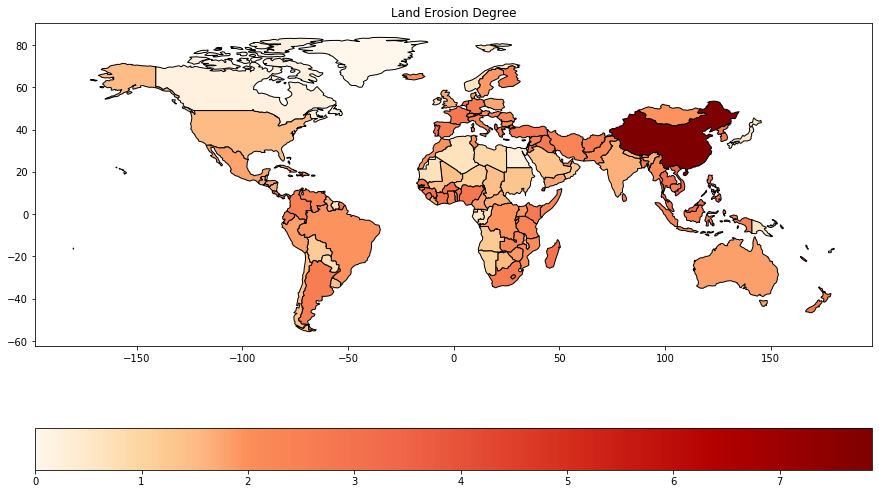

In [145]:
mapp(soil_ers.Value,'Land Erosion Degree',log=False)

## Water

In [146]:
water = pd.read_csv(er+WATER, encoding='latin-1')
water.head()

,CountryCode,Country,ItemCode,Item,ElementGroup,ElementCode,Element,Year,Unit,Value,Flag
0,2,Afghanistan,6720,Water withdrawal for agricultural use,7222,7222,% of total water withdrawal,1987,%,99.00,Fc
1,3,Albania,6720,Water withdrawal for agricultural use,7222,7222,% of total water withdrawal,1990,%,83.33,Fc
2,3,Albania,6720,Water withdrawal for agricultural use,7222,7222,% of total water withdrawal,2000,%,57.61,Fc
3,3,Albania,6720,Water withdrawal for agricultural use,7222,7222,% of total water withdrawal,2006,%,39.69,Fc
4,4,Algeria,6720,Water withdrawal for agricultural use,7222,7222,% of total water withdrawal,1980,%,74.00,Fc


In [147]:
water['Element'].value_counts()

% of total water withdrawal    428
Name: Element, dtype: int64

In [148]:
water = water.drop(columns=['CountryCode','Unit','Element','ElementCode','ElementGroup','Flag','Item','ItemCode'])
water = water.rename(columns={'Country':'Area'})
water.head()

,Area,Year,Value
0,Afghanistan,1987,99.00
1,Albania,1990,83.33
2,Albania,2000,57.61
3,Albania,2006,39.69
4,Algeria,1980,74.00


In [149]:
water = water.replace(changes)
water = water.loc[water.Area.map(lambda x: x in countries),:]
water = water.groupby(['Area']).mean().drop(['Year'],axis=1)
water = water[water.Value>0.1]
water.head()

,Value
Area,
Afghanistan,99.000000
Albania,60.210000
Algeria,65.063333
Angola,43.673333
Argentina,70.685000


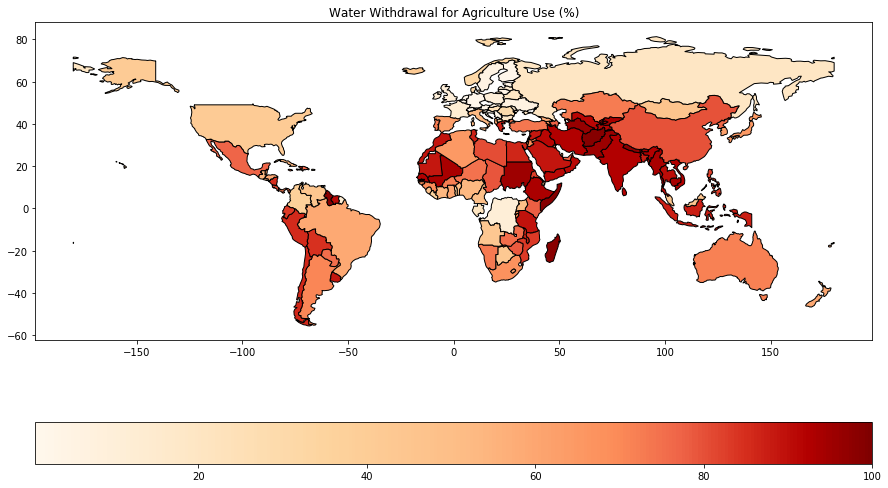

In [150]:
mapp(water.Value,'Water Withdrawal for Agriculture Use (%)',log=False)

## Energy

In [151]:
energy = pd.read_csv(er+ENERGY, encoding='latin-1')
energy.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1986,1986,Terajoule,288659.0,Fc
1,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1987,1987,Terajoule,313771.0,Fc
2,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1988,1988,Terajoule,329896.0,Fc
3,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1989,1989,Terajoule,355094.0,Fc
4,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1990,1990,Terajoule,379045.0,Fc


In [152]:
energy = energy[energy.Year >= 2000]

In [153]:
energy['Element'].value_counts()

Consumption in Agriculture             23998
Emissions (CO2eq) from N2O (Energy)    22067
Emissions (N2O) (Energy)               22067
Emissions (CO2eq) (Energy)             22067
Emissions (CO2eq) from CH4 (Energy)    22067
Emissions (CH4) (Energy)               22067
Emissions (CO2) (Energy)               22041
Implied emission factor for N2O        11061
Implied emission factor for CH4        11061
Implied emission factor for CO2        11035
Name: Element, dtype: int64

In [154]:
energy = energy[energy.Element=='Consumption in Agriculture']

In [155]:
energy['Item'].value_counts()

Electricity                                           3862
Transport fuel used in agriculture (excl. fishery)    2463
Energy used in fishery                                2274
Fuel oil used in fisheries                            2257
Gas-diesel oils used in fisheries                     2257
Total Energy                                          2227
Energy for power irrigation                           2113
Gas-Diesel oil                                        1885
Fuel oil                                              1143
Motor Gasoline                                        1014
Liquefied petroleum gas (LPG)                          950
Natural gas (including LNG)                            909
Coal                                                   644
Name: Item, dtype: int64

In [156]:
energy = energy.drop(columns=['Country Code','Element','Element Code','Year Code','Flag'])

In [157]:
energy.groupby(['Item','Unit']).count()

Country  \
Item                                               Unit                   
Coal                                               Terajoule        644   
Electricity                                        Terajoule       1931   
                                                   million kWh     1931   
Energy for power irrigation                        Terajoule       2113   
Energy used in fishery                             Terajoule       2274   
Fuel oil                                           Terajoule       1143   
Fuel oil used in fisheries                         Terajoule       2257   
Gas-Diesel oil                                     Terajoule       1885   
Gas-diesel oils used in fisheries                  Terajoule       2257   
Liquefied petroleum gas (LPG)                      Terajoule        950   
Motor Gasoline                                     Terajoule       1014   
Natural gas (including LNG)                        Terajoule        909   
Total Energy                                       Terajoule       2227   
Transport fuel used in agriculture (excl. fishery) Terajoule       2463   

                                                                Item Code  \
Item                                               Unit                     
Coal                                               Terajoule          644   
Electricity                                        Terajoule         1931   
                                                   million kWh       1931   
Energy for power irrigation                        Terajoule         2113   
Energy used in fishery                             Terajoule         2274   
Fuel oil                                           Terajoule         1143   
Fuel oil used in fisheries                         Terajoule         2257   
Gas-Diesel oil                                     Terajoule         1885   
Gas-diesel oils used in fisheries                  Terajoule         2257   
Liquefied petroleum gas (LPG)                      Terajoule          950   
Motor Gasoline                                     Terajoule         1014   
Natural gas (including LNG)                        Terajoule          909   
Total Energy                                       Terajoule         2227   
Transport fuel used in agriculture (excl. fishery) Terajoule         2463   

                                                                Year  Value  
Item                                               Unit                      
Coal                                               Terajoule     644    644  
Electricity                                        Terajoule    1931   1931  
                                                   million kWh  1931   1931  
Energy for power irrigation                        Terajoule    2113   2113  
Energy used in fishery                             Terajoule    2274   2274  
Fuel oil                                           Terajoule    1143   1143  
Fuel oil used in fisheries                         Terajoule    2257   2257  
Gas-Diesel oil                                     Terajoule    1885   1885  
Gas-diesel oils used in fisheries                  Terajoule    2257   2257  
Liquefied petroleum gas (LPG)                      Terajoule     950    950  
Motor Gasoline                                     Terajoule    1014   1014  
Natural gas (including LNG)                        Terajoule     909    909  
Total Energy                                       Terajoule    2227   2227  
Transport fuel used in agriculture (excl. fishery) Terajoule    2463   2463

In [158]:
energy = energy[energy.Unit=='Terajoule']
energy = energy.drop(columns=['Unit'])

In [159]:
energy = energy.replace(changes)
energy = energy.loc[energy.Country.map(lambda x: x in countries),:]
energy.head()

,Country,Item Code,Item,Year,Value
14,China,6801,Gas-Diesel oil,2000,563343.0
15,China,6801,Gas-Diesel oil,2001,591508.0
16,China,6801,Gas-Diesel oil,2002,638249.0
17,China,6801,Gas-Diesel oil,2003,403813.0
18,China,6801,Gas-Diesel oil,2004,469560.0


In [160]:
energy_space = energy.drop(columns=['Item Code','Year']).groupby(['Country','Item']).mean()
energy_space = energy_space.unstack(['Item'])
energy_space.head()

Value                                           \
Item         Coal  Electricity Energy for power irrigation   
Country                                                      
Afghanistan   NaN   207.692308                  989.520000   
Albania       NaN   250.892308                    0.180500   
Algeria       NaN  1256.400000                  347.200000   
Angola        NaN          NaN                         NaN   
Argentina     NaN  2673.692308                 2775.315154   

                                                                        \
Item        Energy used in fishery Fuel oil Fuel oil used in fisheries   
Country                                                                  
Afghanistan                    NaN      NaN                        NaN   
Albania                 845.273769    44.44                        0.0   
Algeria                   0.000000      NaN                        0.0   
Angola                    0.000000      NaN                        0.0   
Argentina               770.707692  1252.40                        0.0   

                                                              \
Item        Gas-Diesel oil Gas-diesel oils used in fisheries   
Country                                                        
Afghanistan            NaN                               NaN   
Albania        2798.307692                        811.089154   
Algeria         673.666667                          0.000000   
Angola          191.846154                          0.000000   
Argentina    129850.076923                          0.000000   

                                                          \
Item        Liquefied petroleum gas (LPG) Motor Gasoline   
Country                                                    
Afghanistan                           NaN            NaN   
Albania                               NaN            NaN   
Algeria                        197.083333            NaN   
Angola                                NaN            NaN   
Argentina                     3649.983333     118.133333   

                                                        \
Item        Natural gas (including LNG)   Total Energy   
Country                                                  
Afghanistan                         NaN     207.692308   
Albania                             NaN    3083.384615   
Algeria                           732.0    2118.775000   
Angola                              NaN     191.846154   
Argentina                           NaN  135006.346154   

                                                                
Item        Transport fuel used in agriculture (excl. fishery)  
Country                                                         
Afghanistan                                                NaN  
Albania                                            1987.218538  
Algeria                                             310.923077  
Angola                                              191.846154  
Argentina                                        129877.338462

C:\Users\Claudio\Anaconda3\envs\ada\lib\site-packages\pandas\core\reshape\merge.py:617: UserWarning:

merging between different levels can give an unintended result (1 levels on the left, 2 on the right)



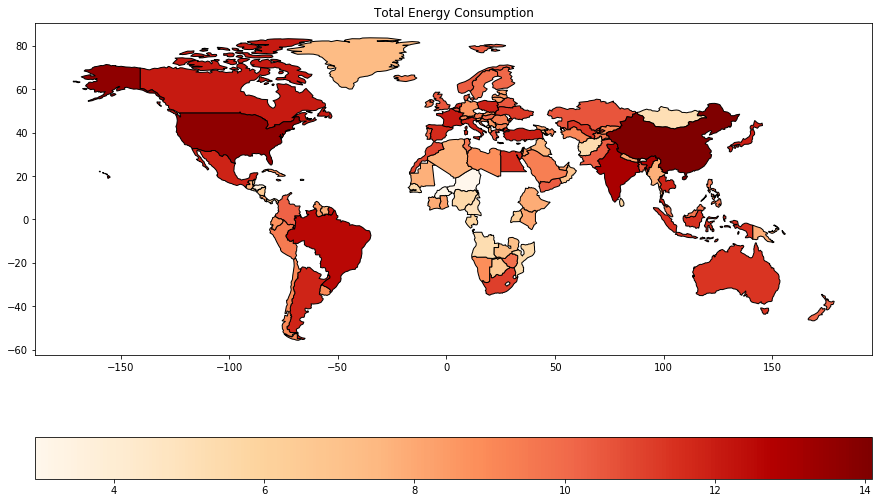

In [161]:
mapp(energy_space[energy_space.columns[11]],'Total Energy Consumption')

In [162]:
energy_time = energy.drop(columns=['Item Code']).groupby(['Item','Year']).sum()
energy_time = energy_time.unstack(['Item'])
energy_time

Value                                                                 \
Item      Coal Electricity Energy for power irrigation Energy used in fishery   
Year                                                                            
2000  488058.6   1077649.2                 128895.2830             347887.911   
2001  469740.6   1103198.4                 140636.3805             368122.466   
2002  480034.8   1274943.6                 145057.2190             372576.321   
2003  343785.0   1244617.2                 132731.1937             442632.421   
2004  434420.4   1297152.0                 137659.1682             450332.266   
2005  455060.4   1338613.2                 234947.7183             354344.816   
2006  448533.0   1389877.2                 279392.9118             338508.792   
2007  453538.2   1404651.6                 292976.4417             342903.005   
2008  453486.6   1455778.8                 292976.4417             321129.103   
2009  479699.4   1515067.2                 293047.8729             288926.053   
2010  521366.4   1550862.0                 294953.3083             266848.200   
2011  537388.2   1580454.0                 312520.2395             262024.331   
2012  548972.4   1608580.8                 317691.9180             265645.080   

                                                          \
Item  Fuel oil Fuel oil used in fisheries Gas-Diesel oil   
Year                                                       
2000  132067.6                 44364.0480      3081079.0   
2001  148914.4                 39514.6340      3112770.0   
2002  146046.0                 37518.1468      3189095.0   
2003  212786.8                 33569.3700      2956078.0   
2004  211817.2                 33122.7884      3253681.0   
2005  117685.2                 28796.0292      3429207.0   
2006  130855.6                 25947.7080      3735109.0   
2007  149964.8                 28892.0600      3348883.0   
2008  137440.8                 23468.1580      3429379.0   
2009  106009.6                 23278.5204      3247618.0   
2010   47591.2                 13452.9980      3445676.0   
2011   42379.6                 13681.8236      3689787.0   
2012   37127.6                 11798.5372      3620299.0   

                                                                      \
Item Gas-diesel oils used in fisheries Liquefied petroleum gas (LPG)   
Year                                                                   
2000                        215820.311                      126196.4   
2001                        219208.066                      132392.7   
2002                        226530.321                      132014.3   
2003                        229845.621                      111155.0   
2004                        238515.066                      111202.3   
2005                        236659.616                      121371.8   
2006                        207653.192                      112479.4   
2007                        192938.205                      116121.5   
2008                        183688.303                      118250.0   
2009                        182916.453                      114891.7   
2010                        219257.000                      120756.9   
2011                        219644.731                      120756.9   
2012                        228517.480                      115270.1   

                                                              \
Item Motor Gasoline Natural gas (including LNG) Total Energy   
Year                                                           
2000       187034.6                    235560.0    5327645.4   
2001       204798.9                    232812.0    5404627.0   
2002       210557.9                    321076.0    5753767.6   
2003       180212.4                    330804.0    5379438.4   
2004       221411.4                    336025.0    5865709.3   
2005       231910.5                    314628.0    6008476.1   
2006       257338.7   

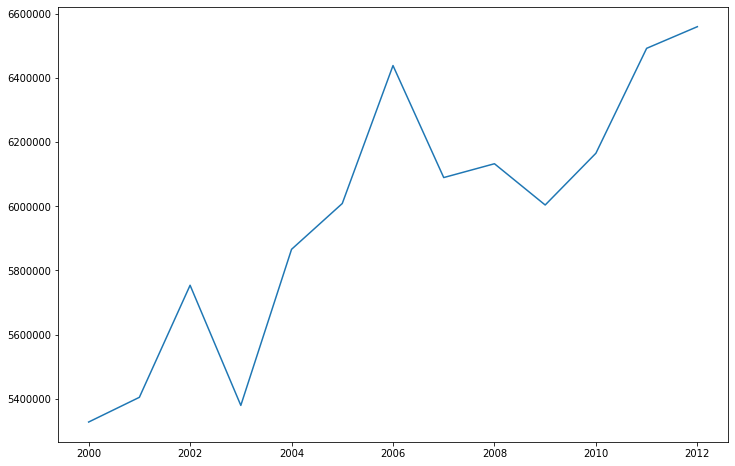

In [163]:
plt.figure(figsize=(12,8))
plt.plot(energy_time[energy_time.columns[11]])

## Climate Change

In [164]:
climate_change = pd.read_csv(en+CLIMATE,encoding = "ISO-8859-1")

In [165]:
climate_change = climate_change[climate_change.Element=='Temperature change']
climate_change = climate_change[climate_change.Months=='Meteorological year']
climate_change.head()

,Area Code,Area,Months Code,Months,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018
32,2,Afghanistan,7020,Meteorological year,7271,Temperature change,°C,-0.059,-0.154,0.820,...,1.633,1.881,1.787,0.722,1.251,1.299,1.414,1.817,1.716,2.029
66,3,Albania,7020,Meteorological year,7271,Temperature change,°C,0.656,0.318,0.072,...,0.848,0.936,0.701,1.478,1.420,1.157,1.321,1.307,0.990,1.656
100,4,Algeria,7020,Meteorological year,7271,Temperature change,°C,0.378,0.220,0.077,...,0.873,2.151,1.351,1.103,1.181,1.697,1.173,1.862,1.520,1.196
134,5,American Samoa,7020,Meteorological year,7271,Temperature change,°C,-0.085,-0.188,-0.024,...,0.999,NaN,0.582,0.496,0.822,0.819,0.563,1.079,0.988,0.738
168,6,Andorra,7020,Meteorological year,7271,Temperature change,°C,0.691,0.107,-0.719,...,1.443,0.459,1.744,1.357,0.779,1.958,1.547,1.825,1.774,1.822


In [166]:
to_drop = ['Area Code','Months Code','Element Code']

In [167]:
climate_change = climate_change.fillna(0)

In [168]:
climate_change.columns = climate_change.columns.str.replace('Y', '')
climate_change  = climate_change.set_index('Area')
climate_change = climate_change.drop(['Area Code','Months Code','Months','Element Code','Element','Unit'], axis=1)
climate_change = climate_change.stack()
climate_change = climate_change.reset_index()
climate_change = climate_change.rename(columns={'level_1': 'YEAR', 0: 'Total'})

In [169]:
def for_complete(df,complete,name):
    df['YEAR'] = df['YEAR'].astype(int)
    df = df[(df.YEAR>=1961) | (df.YEAR<=2014)]
    df = df.set_index(['Area','YEAR'])
    complete = complete.set_index(['Area','YEAR'])
    complete[name] = df ['Total'] 
    return complete.reset_index()

In [170]:
l = [interactive_live_stock,interactive_values,emissions_live_stock_interactive,emissions_crop_interactive,\
     climate_change,\
     fertilizers_interactive,pesticides_interactive,trade_import_interactive,trade_export_interactive]
l_name = ['Live_stock','Agricultural_values','emission_live_stock','emission_crop',\
          'Climate_change','fertilizers','pesticides','trade_import','trade_export']

In [171]:
complete

,Area,YEAR,Crops
0,China,1961,12.732762
1,China,1962,12.929771
2,China,1963,13.158951
3,China,1964,13.187608
4,China,1965,14.240274
...,...,...,...
8905,Brunei,2010,0.000272
8906,Brunei,2011,0.000268
8907,Brunei,2012,0.000271
8908,Brunei,2013,0.000260


In [172]:
for i in range(len(l)):
    complete = for_complete(l[i],complete,l_name[i])

In [173]:
complete.head()

,Area,YEAR,Crops,Live_stock,Agricultural_values,emission_live_stock,emission_crop,Climate_change,fertilizers,pesticides,trade_import,trade_export
0,China,1961,12.732762,4.471145,8.769722,6.164433,19.194828,0.276,2.388758,NaN,3.033858,1.615278
1,China,1962,12.929771,4.910284,8.933013,5.958853,19.013760,-0.122,2.987113,NaN,2.756072,1.824787
2,China,1963,13.158951,6.602564,9.301101,6.152220,19.460080,0.287,3.397942,NaN,2.914984,2.137379
3,China,1964,13.187608,7.905126,9.765911,6.539071,20.156483,-0.014,4.098548,NaN,2.979591,2.415547
4,China,1965,14.240274,8.489235,10.455727,6.744195,20.429136,0.089,5.660183,NaN,2.940981,2.534051


In [174]:
complete.to_pickle("./complete.pkl")

In [175]:
complete = complete.rename(columns={"YEAR":"Year"})

In [176]:
def plot_func(countries,features):
    countries = list(countries)
    features = list(features)
    plot = compare_different_country(complete, country=countries, feature=features, plot=True)
    return

In [177]:
f = list(complete.columns)
f.remove('Area')
f.remove('Year')
c1=set(['China', 'United States of America', 'India', 'Brazil', 'Indonesia',
       'Russia', 'Nigeria', 'France', 'Argentina', 'Thailand'])
c2=set(['China', 'United States of America', 'India', 'Brazil', 'Russia',
       'Germany', 'France', 'Pakistan', 'Mexico', 'Spain'])
c = list(c1.union(c2))

In [178]:
s_c = SelectMultiple(options=c,description='country',rows=len(c),layout=Layout(width="100%"))
s_f = SelectMultiple(options=f,rows=len(f),layout=Layout(width="100%"))

interact(plot_func, countries= s_c , features = s_f)

interactive(children=(SelectMultiple(description='country', layout=Layout(width='100%'), options=('China', 'Pa…

<function __main__.plot_func(countries, features)>

In [179]:
complete.head()

,Area,Year,Crops,Live_stock,Agricultural_values,emission_live_stock,emission_crop,Climate_change,fertilizers,pesticides,trade_import,trade_export
0,China,1961,12.732762,4.471145,8.769722,6.164433,19.194828,0.276,2.388758,NaN,3.033858,1.615278
1,China,1962,12.929771,4.910284,8.933013,5.958853,19.013760,-0.122,2.987113,NaN,2.756072,1.824787
2,China,1963,13.158951,6.602564,9.301101,6.152220,19.460080,0.287,3.397942,NaN,2.914984,2.137379
3,China,1964,13.187608,7.905126,9.765911,6.539071,20.156483,-0.014,4.098548,NaN,2.979591,2.415547
4,China,1965,14.240274,8.489235,10.455727,6.744195,20.429136,0.089,5.660183,NaN,2.940981,2.534051


In [180]:
l_df =list(complete.columns)
l_df.remove('Area')
l_df.remove('Year')

In [181]:
def plot_func(df,year):
    result = complete[['Area','Year']+[str(df)]]
    result = result.set_index('Area')
    result = result[result['Year']==year]
    result = result.rename(columns={"Year": "YEAR"})
    result = result.rename(columns={str(df): "Total"})
    return mapp_interactive(result)

In [182]:
interact(plot_func, df = l_df ,year = range(1961,2014))

interactive(children=(Dropdown(description='df', options=('Crops', 'Live_stock', 'Agricultural_values', 'emiss…

<function __main__.plot_func(df, year)>

# VIDEO LINKS

Since it's not possible to do interactive plots in a notebook on Jupyter, we decided to show our results in the following videos. 

[Time Series](https://streamable.com/lum73)


[Choropleth Maps](https://streamable.com/it97j)

In [192]:
IndiaProd = crops_production.loc["India",].values
IndiaFert = fertilizers.loc["India",].values

In [194]:
corr = np.correlate(IndiaProd,IndiaFert,mode="full")

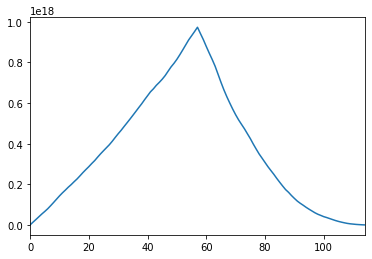